# Friday Summary & Consolidated Action Items

**Author**: Ahmad Jalil  
**Purpose**: Consolidated notebook addressing all action items from the Ann meeting (Jan 28, 2026)

## Notebook Structure

| Section | Task | Status |
|---------|------|--------|
| **0** | Setup & Data Loading | |
| **1** | PMF Replication: KF-based Source Fractions (Naveed's Figure 7) | Friday slide (a) |
| **2** | Source Concentration Time Series (KF µg/m³) | Friday slide (a) |
| **3** | Source Grouping: Biomass vs Fossil Fuel (combined & separate) | Ann feedback #2 |
| **4** | Cross-Plots by Source Type with Slopes | Friday slide (b) |
| **5** | Threshold Analysis with Grouped Categories | |
| **6** | Seasonal Write-Up: Concentration Patterns | Ann feedback #1 |
| **7** | Notes & Flags | GF removal, Addis vs Delhi |

### Key Decisions from Meeting
- **Use KF (concentration) values**, NOT GF (mass fractions) — Ann said drop GF entirely
- **Try both**: fossil fuel + polluted marine combined AND separate
- **Exclude sea salt** (only 3 samples)
- **FTIR EC on X-axis** consistently
- **Standardize colors** and increase font sizes

---

## Section 0: Setup & Data Loading

In [111]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

# Resolve repository root and load FTIR/HIPS research scripts
cwd = Path.cwd().resolve()
repo_root = next((p for p in [cwd, *cwd.parents] if (p / 'pyproject.toml').exists()), cwd)
scripts_path = repo_root / 'research' / 'ftir_hips_chem' / 'scripts'
notebook_dir = str((repo_root / 'notebooks').resolve())
for p in (repo_root, scripts_path):
    p_str = str(p)
    if p_str not in sys.path:
        sys.path.insert(0, p_str)

from config import SITES, MAC_VALUE
from data_matching import (
    load_aethalometer_data,
    load_filter_data,
    add_base_filter_id,
    match_all_parameters,
    load_etad_factors_with_filter_ids,
)

print(f"MAC value: {MAC_VALUE} m²/g")

MAC value: 10 m²/g


In [112]:
# =============================================================================
# Global Configuration
# =============================================================================

ADDIS_CONFIG = {
    'name': 'Addis_Ababa',
    'code': 'ETAD',
    'timezone': 'Africa/Addis_Ababa',
}

# Ethiopian seasons
SEASONS = {
    'Dry Season': [10, 11, 12, 1, 2],
    'Belg Rainy Season': [3, 4, 5],
    'Kiremt Rainy Season': [6, 7, 8, 9]
}
SEASONS_ORDER = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
SEASON_COLORS = {
    'Dry Season': '#E67E22',
    'Belg Rainy Season': '#27AE60',
    'Kiremt Rainy Season': '#3498DB'
}

# 4-season classification for Figure 7 style plots
SEASON_DEFS = [
    ('First Dry',   [1, 2],          '#FFDAB9'),
    ('Less Rainy',  [3, 4, 5],       '#B0C4DE'),
    ('More Rainy',  [6, 7, 8, 9],    '#87CEEB'),
    ('Second Dry',  [10, 11, 12],    '#F4A460'),
]

def get_season(month):
    for name, months, _ in SEASON_DEFS:
        if month in months:
            return name
    return None

def get_season_3(month):
    """3-season Ethiopian classification."""
    for season, months in SEASONS.items():
        if month in months:
            return season
    return None

# =============================================================================
# STANDARDIZED SOURCE COLORS (consistent across all plots)
# =============================================================================

# --- Original 5 sources ---
SOURCE_CATEGORIES = {
    'charcoal':        {'label': 'Charcoal Burning',        'color': '#2C3E50', 'marker': 'o'},
    'wood':            {'label': 'Wood Burning',            'color': '#8B4513', 'marker': 's'},
    'fossil_fuel':     {'label': 'Fossil Fuel Combustion',  'color': '#7D3C98', 'marker': '^'},
    'polluted_marine': {'label': 'Polluted Marine',         'color': '#2980B9', 'marker': 'D'},
    'sea_salt':        {'label': 'Sea Salt Mixed',          'color': '#1ABC9C', 'marker': 'v'},
}
SOURCE_ORDER = ['charcoal', 'wood', 'fossil_fuel', 'polluted_marine', 'sea_salt']

# --- Grouped sources (Ann's request) ---
GROUPED_SOURCE_CATEGORIES = {
    'biomass_burning':       {'label': 'Biomass Burning\n(Charcoal + Wood)',           'color': '#556B2F', 'marker': 'o'},
    'fossil_fuel_combustion':{'label': 'Fossil Fuel Combustion\n(Fossil + Poll. Marine)', 'color': '#8B0000', 'marker': '^'},
    'sea_salt':              {'label': 'Sea Salt Mixed',                                 'color': '#1ABC9C', 'marker': 'v'},
}
GROUPED_SOURCE_ORDER = ['biomass_burning', 'fossil_fuel_combustion', 'sea_salt']

# --- Stacking colors for time series (matching Naveed's Figure 7) ---
STACK_COLORS = {
    'fossil_fuel':     '#F8C8DC',   # light pink
    'polluted_marine': '#DC143C',   # crimson red
    'sea_salt':        '#0000CD',   # medium blue
    'wood':            '#90EE90',   # light green
    'charcoal':        '#228B22',   # forest green
}

# Dominance thresholds
DOMINANCE_THRESHOLDS = [0.30, 0.40, 0.50, 0.60]

# Measurement pairs (FTIR EC always on X-axis per Ann's instruction)
MEASUREMENT_PAIRS = [
    ('ftir_ec', 'hips_fabs', 'FTIR EC (µg/m³)', 'HIPS Fabs/MAC (µg/m³)', 'hips_vs_ec'),
    ('ftir_ec', 'ir_bcc',    'FTIR EC (µg/m³)', 'Aeth IR BCc (µg/m³)',   'aeth_vs_ec'),
    ('hips_fabs', 'ir_bcc',  'HIPS Fabs/MAC (µg/m³)', 'Aeth IR BCc (µg/m³)', 'aeth_vs_hips'),
]

# Font size configuration (increased per Ann's feedback)
FONT_CONFIG = {
    'title': 16,
    'axis_label': 14,
    'tick': 12,
    'legend': 12,
    'annotation': 11,
    'stats_box': 11,
}

plt.rcParams.update({
    'font.size': FONT_CONFIG['tick'],
    'axes.titlesize': FONT_CONFIG['title'],
    'axes.labelsize': FONT_CONFIG['axis_label'],
    'xtick.labelsize': FONT_CONFIG['tick'],
    'ytick.labelsize': FONT_CONFIG['tick'],
    'legend.fontsize': FONT_CONFIG['legend'],
})

# Output directories
output_root = repo_root / 'artifacts' / 'notebook_outputs' / 'friday_summary_consolidated'
dirs = {}
for d in ['plots', 'data', 'friday_slides']:
    path = output_root / d
    path.mkdir(parents=True, exist_ok=True)
    dirs[d] = str(path)

print("Configuration ready")
print(f"Output dirs: {list(dirs.values())}")

Configuration ready
Output dirs: ['/Users/ahmadjalil/github/aethmodular/artifacts/notebook_outputs/friday_summary_consolidated/plots', '/Users/ahmadjalil/github/aethmodular/artifacts/notebook_outputs/friday_summary_consolidated/data', '/Users/ahmadjalil/github/aethmodular/artifacts/notebook_outputs/friday_summary_consolidated/friday_slides']


In [113]:
# =============================================================================
# Column Mappings: GF (fraction) and K_F (concentration)
# =============================================================================

# GF fraction columns → internal names
FACTOR_TO_FRAC = {
    'GF3 (Charcoal)':              'charcoal_frac',
    'GF2 (Wood Burning)':          'wood_frac',
    'GF5 (Fossil Fuel Combustion)':'fossil_fuel_frac',
    'GF4 (Polluted Marine)':       'polluted_marine_frac',
    'GF1 (Sea Salt Mixed)':        'sea_salt_frac',
}

# K_F concentration columns → internal names
FACTOR_TO_CONC = {
    'K_F3 Charcoal (ug/m3)':              'charcoal_conc',
    'K_F2 Wood Burning (ug/m3)':           'wood_conc',
    'K_F5 Fossil Fuel Combustion (ug/m3)': 'fossil_fuel_conc',
    'K_F4 Polluted Marine (ug/m3)':        'polluted_marine_conc',
    'K_F1 Sea Salt Mixed (ug/m3)':         'sea_salt_conc',
}

frac_cols = list(FACTOR_TO_FRAC.values())
conc_cols = list(FACTOR_TO_CONC.values())

In [114]:
# =============================================================================
# Load and Merge All Data
# =============================================================================

# 1. Load factor contributions with Filter IDs
factors_df = load_etad_factors_with_filter_ids()
factors_df = factors_df.rename(columns={**FACTOR_TO_FRAC, **FACTOR_TO_CONC})

print(f"Factor contributions: {len(factors_df)} samples")
print(f"Date range: {factors_df['date'].min().date()} to {factors_df['date'].max().date()}")
print(f"\nFrac columns present: {[c for c in frac_cols if c in factors_df.columns]}")
print(f"Conc columns present: {[c for c in conc_cols if c in factors_df.columns]}")

# 2. Load aethalometer + filter measurements
aethalometer_data = load_aethalometer_data()
filter_data = load_filter_data()
filter_data = add_base_filter_id(filter_data)

df_aeth = aethalometer_data.get('Addis_Ababa')
bc_df = match_all_parameters('Addis_Ababa', 'ETAD', df_aeth, filter_data)

# 3. Merge BC/EC measurements with factor contributions via base_filter_id
etad_filters = filter_data[filter_data['Site'] == 'ETAD'][['SampleDate', 'FilterId']].drop_duplicates()
etad_filters = etad_filters.rename(columns={'SampleDate': 'date', 'FilterId': 'base_filter_id'})
bc_df['date'] = pd.to_datetime(bc_df['date'])
etad_filters['date'] = pd.to_datetime(etad_filters['date'])

bc_with_id = pd.merge(bc_df, etad_filters, on='date', how='left')

factor_merge_cols = ['base_filter_id'] + frac_cols + conc_cols
available_merge_cols = [c for c in factor_merge_cols if c in factors_df.columns]
df = pd.merge(bc_with_id, factors_df[available_merge_cols], on='base_filter_id', how='left')

# Add month and season columns
df['Month'] = df['date'].dt.month
df['season_4'] = df['Month'].apply(get_season)
df['season_3'] = df['Month'].apply(get_season_3)

print(f"\nMerged dataset: {len(df)} samples")
print(f"Columns: {sorted(df.columns.tolist())}")

ETAD factor contributions loaded: 102 records
Date range: 2023-01-03 to 2023-12-17
ETAD Filter IDs loaded: 189 filters
Date range: 2022-12-07 to 2024-09-12
Merged: 102 records (0 factor rows had no matching FilterId)
Factor contributions: 102 samples
Date range: 2023-01-03 to 2023-12-17

Frac columns present: ['charcoal_frac', 'wood_frac', 'fossil_fuel_frac', 'polluted_marine_frac', 'sea_salt_frac']
Conc columns present: ['charcoal_conc', 'wood_conc', 'fossil_fuel_conc', 'polluted_marine_conc', 'sea_salt_conc']
Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08

Merged dataset: 378 samples
Columns: ['Month', 'base_filter_id', 'charcoal_conc', 'charcoal_frac', 'date', 'fossil_fuel_conc', 'f

In [115]:
# =============================================================================
# KF-Based Dominance Determination (Ann: use KF, drop GF)
# =============================================================================

# Map conc columns to source keys
CONC_TO_SOURCE = {
    'charcoal_conc':        'charcoal',
    'wood_conc':            'wood',
    'fossil_fuel_conc':     'fossil_fuel',
    'polluted_marine_conc': 'polluted_marine',
    'sea_salt_conc':        'sea_salt',
}

available_conc = [c for c in conc_cols if c in df.columns]

if available_conc:
    # Dominant source by KF concentration
    df['dominant_conc_col'] = df[available_conc].idxmax(axis=1)
    df['dominant_source'] = df['dominant_conc_col'].map(CONC_TO_SOURCE)
    
    # KF sum and dominant fraction
    df['kf_total'] = df[available_conc].sum(axis=1)
    df['dominant_kf_value'] = df[available_conc].max(axis=1)
    df['dominant_fraction'] = df['dominant_kf_value'] / df['kf_total']
    
    # --- Compute KF-based source fractions (Ann: recalculate using KF) ---
    for conc_col, source_key in CONC_TO_SOURCE.items():
        if conc_col in df.columns:
            df[f'{source_key}_kf_frac'] = df[conc_col] / df['kf_total']
    
    print("\nDominant Source Distribution (KF-based):")
    print(df['dominant_source'].value_counts())
    print(f"\nMean KF total: {df['kf_total'].mean():.3f} µg/m³")
    print(f"Mean dominant fraction: {df['dominant_fraction'].mean():.2%}")
else:
    print("WARNING: No K_F concentration columns found. Check data loading.")


Dominant Source Distribution (KF-based):
dominant_source
charcoal           41
wood               24
polluted_marine    21
fossil_fuel        13
sea_salt            3
Name: count, dtype: int64

Mean KF total: 1.557 µg/m³
Mean dominant fraction: 47.77%


In [116]:
# =============================================================================
# Create Grouped Source Categories
# (charcoal + wood → biomass; fossil fuel + polluted marine → fossil fuel comb.)
# =============================================================================

# Grouped concentrations
if 'charcoal_conc' in df.columns and 'wood_conc' in df.columns:
    df['biomass_conc'] = df['charcoal_conc'].fillna(0) + df['wood_conc'].fillna(0)
if 'fossil_fuel_conc' in df.columns and 'polluted_marine_conc' in df.columns:
    df['fossil_comb_conc'] = df['fossil_fuel_conc'].fillna(0) + df['polluted_marine_conc'].fillna(0)

# Grouped KF fractions
if 'kf_total' in df.columns:
    df['biomass_kf_frac'] = df['biomass_conc'] / df['kf_total']
    df['fossil_comb_kf_frac'] = df['fossil_comb_conc'] / df['kf_total']
    df['sea_salt_kf_frac'] = df.get('sea_salt_conc', 0) / df['kf_total']

# Grouped dominant source
grouped_conc_cols = ['biomass_conc', 'fossil_comb_conc']
if 'sea_salt_conc' in df.columns:
    grouped_conc_cols.append('sea_salt_conc')

GROUPED_CONC_MAP = {
    'biomass_conc': 'biomass_burning',
    'fossil_comb_conc': 'fossil_fuel_combustion',
    'sea_salt_conc': 'sea_salt',
}

available_grouped = [c for c in grouped_conc_cols if c in df.columns]
df['dominant_source_grouped'] = df[available_grouped].idxmax(axis=1).map(GROUPED_CONC_MAP)
df['dominant_grouped_value'] = df[available_grouped].max(axis=1)
df['grouped_total'] = df[available_grouped].sum(axis=1)
df['dominant_fraction_grouped'] = df['dominant_grouped_value'] / df['grouped_total']

print("Grouped Source Distribution:")
print(df['dominant_source_grouped'].value_counts())
print(f"\nSea salt samples: {(df['dominant_source_grouped'] == 'sea_salt').sum()} — will be excluded")

Grouped Source Distribution:
dominant_source_grouped
biomass_burning           342
fossil_fuel_combustion     34
sea_salt                    2
Name: count, dtype: int64

Sea salt samples: 2 — will be excluded


---

# Section 1: PMF Replication — KF-Based Source Fractions

**Task**: Recalculate Naveed's fractional source plot using KF values  
**Method**: Sum KF per day, divide each source by total → fraction  
**Goal**: Verify recalculated fractions match Naveed's Figure 7

---

In [117]:
# =============================================================================
# Figure 7 Replication: KF-Based Normalized Source Fractions (Stacked Bars)
# =============================================================================

# Stacking order: bottom to top (matching Naveed)
KF_FRAC_STACK = [
    ('fossil_fuel_kf_frac',     'Fossil Fuel Combustion', '#F8C8DC'),
    ('polluted_marine_kf_frac', 'Polluted Marine',        '#DC143C'),
    ('sea_salt_kf_frac',        'Sea Salt Mixed',         '#0000CD'),
    ('wood_kf_frac',            'Wood Burning',           '#90EE90'),
    ('charcoal_kf_frac',        'Charcoal',               '#228B22'),
]

kf_frac_col_names = [col for col, _, _ in KF_FRAC_STACK]
valid_kf = df.dropna(subset=[c for c in kf_frac_col_names if c in df.columns]).copy()
valid_kf = valid_kf.sort_values('date').reset_index(drop=True)
valid_kf['season'] = valid_kf['Month'].apply(get_season)

print(f"Plotting {len(valid_kf)} samples")
print(f"Date range: {valid_kf['date'].min().date()} to {valid_kf['date'].max().date()}")

# Spot check: do KF fractions sum to ~1.0?
row_sums = valid_kf[kf_frac_col_names].sum(axis=1)
print(f"\nKF fraction row sums: mean={row_sums.mean():.4f}, min={row_sums.min():.4f}, max={row_sums.max():.4f}")
print("(Should be ~1.0 since we divided each KF by daily KF total)")

Plotting 102 samples
Date range: 2023-01-03 to 2023-12-17

KF fraction row sums: mean=1.0000, min=1.0000, max=1.0000
(Should be ~1.0 since we divided each KF by daily KF total)


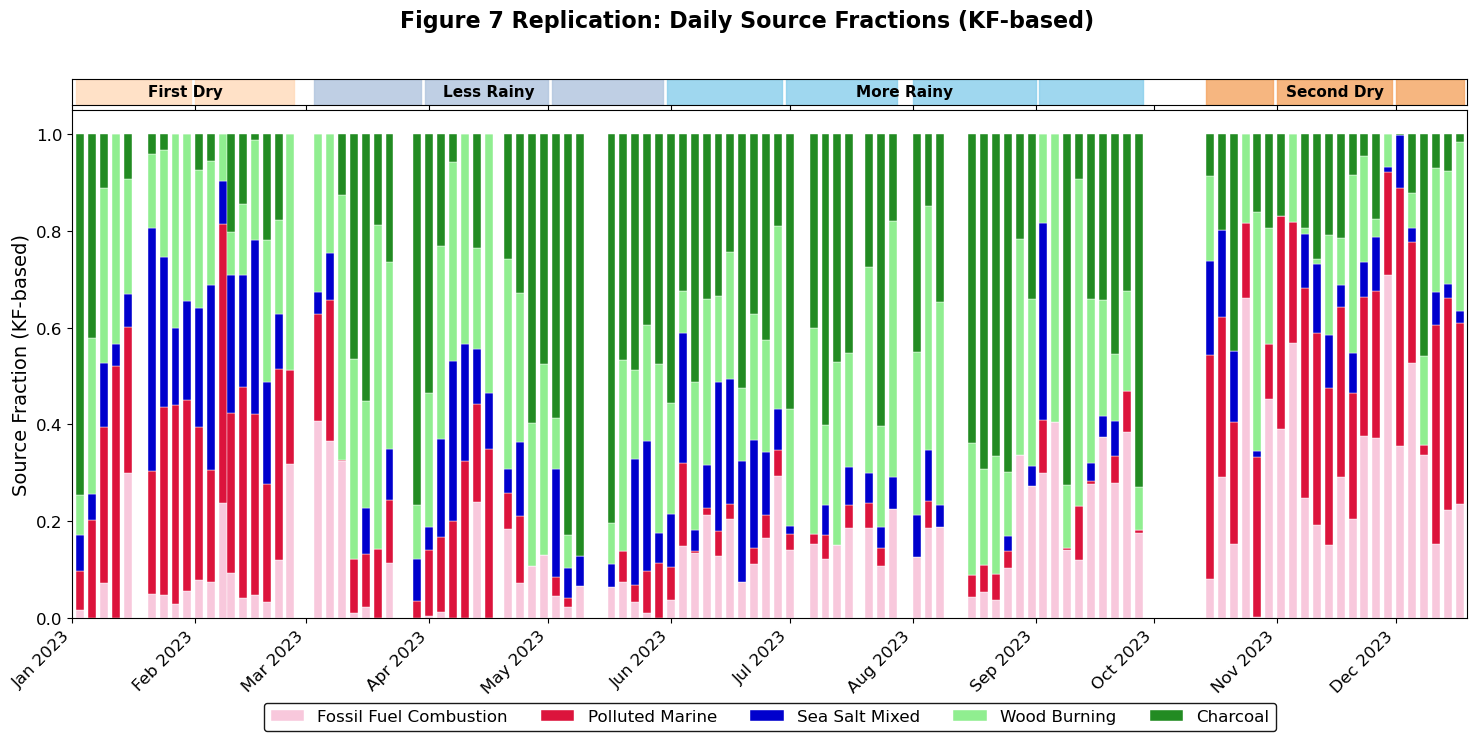


✓ FRIDAY SLIDE (a) — KF-based fraction time series saved


In [118]:
# =============================================================================
# Plot: KF-Based Normalized Source Fractions (Figure 7 Replication)
# =============================================================================

fig, (ax_season, ax) = plt.subplots(
    2, 1, figsize=(18, 7),
    gridspec_kw={'height_ratios': [1, 20], 'hspace': 0.02},
    sharex=True
)

dates = valid_kf['date'].values
bar_width = 2.0
x_dates = mdates.date2num(dates)

# Stacked bars
bottom = np.zeros(len(valid_kf))
for col, label, color in KF_FRAC_STACK:
    if col in valid_kf.columns:
        values = valid_kf[col].values
        ax.bar(x_dates, values, width=bar_width, bottom=bottom,
               color=color, label=label, edgecolor='white', linewidth=0.3)
        bottom += values

# Season strip
season_color_map = {name: color for name, _, color in SEASON_DEFS}
date_min = x_dates.min() - bar_width
date_max = x_dates.max() + bar_width

# Color each month block
for name, months, color in SEASON_DEFS:
    for m in months:
        mask = valid_kf['Month'] == m
        if mask.any():
            m_dates = x_dates[mask]
            ax_season.axvspan(m_dates.min() - bar_width/2, m_dates.max() + bar_width/2,
                             color=color, alpha=0.8)

# Season labels
for name, months, color in SEASON_DEFS:
    mask = valid_kf['Month'].isin(months)
    if mask.any():
        m_dates = x_dates[mask]
        mid = (m_dates.min() + m_dates.max()) / 2
        ax_season.text(mid, 0.5, name, ha='center', va='center',
                      fontsize=FONT_CONFIG['annotation'], fontweight='bold',
                      transform=ax_season.get_xaxis_transform())

ax_season.set_yticks([])
ax_season.set_xlim(date_min, date_max)

# Title above everything (on the figure, not overlapping season strip)
fig.suptitle('Figure 7 Replication: Daily Source Fractions (KF-based)',
             fontsize=FONT_CONFIG['title'], fontweight='bold', y=0.98)

ax.set_ylabel('Source Fraction (KF-based)', fontsize=FONT_CONFIG['axis_label'])
ax.set_ylim(0, 1.05)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Legend below the plot to avoid overlapping bars
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=5, fontsize=FONT_CONFIG['legend'],
          framealpha=0.9, edgecolor='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(dirs['friday_slides'], 'fig7_kf_fractions.png'),
            dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ FRIDAY SLIDE (a) — KF-based fraction time series saved")

In [119]:
# =============================================================================
# Verification: Spot-check KF fractions vs Naveed's Figure 7
# =============================================================================

print("Spot-check: KF-based source fractions for selected dates")
print("=" * 100)
header = f"{'Date':<14s} {'Fossil Fuel':>12s} {'Polluted Mar':>12s} {'Sea Salt':>12s} {'Wood Burn':>12s} {'Charcoal':>12s} {'Total':>8s}"
print(header)
print("-" * 100)

check_dates = valid_kf.iloc[::10]  # every 10th sample
for _, row in check_dates.iterrows():
    total = sum(row.get(col, 0) for col, _, _ in KF_FRAC_STACK)
    vals = [f"{row.get(col, 0):12.3f}" for col, _, _ in KF_FRAC_STACK]
    print(f"{str(row['date'].date()):<14s} {'  '.join(vals)} {total:8.3f}")

Spot-check: KF-based source fractions for selected dates
Date            Fossil Fuel Polluted Mar     Sea Salt    Wood Burn     Charcoal    Total
----------------------------------------------------------------------------------------------------
2023-01-03            0.016         0.081         0.075         0.082         0.746    1.000
2023-02-05            0.074         0.233         0.381         0.257         0.055    1.000
2023-03-10            0.325         0.001         0.000         0.548         0.126    1.000
2023-04-13            0.240         0.202         0.114         0.208         0.236    1.000
2023-05-20            0.074         0.065         0.000         0.396         0.466    1.000
2023-06-19            0.075         0.000         0.249         0.153         0.524    1.000
2023-07-24            0.109         0.036         0.044         0.209         0.603    1.000
2023-08-31            0.273         0.000         0.041         0.346         0.340    1.000
2023-10-1

---

# Section 2: Source Concentration Time Series (KF µg/m³)

**Friday Slide (a)**: Stacked bar chart of source concentrations over time.  
**Write-up needed**: Note patterns — higher concentrations during rain? Higher biomass in summer?

---

Plotting 102 samples
Date range: 2023-01-03 to 2023-12-17


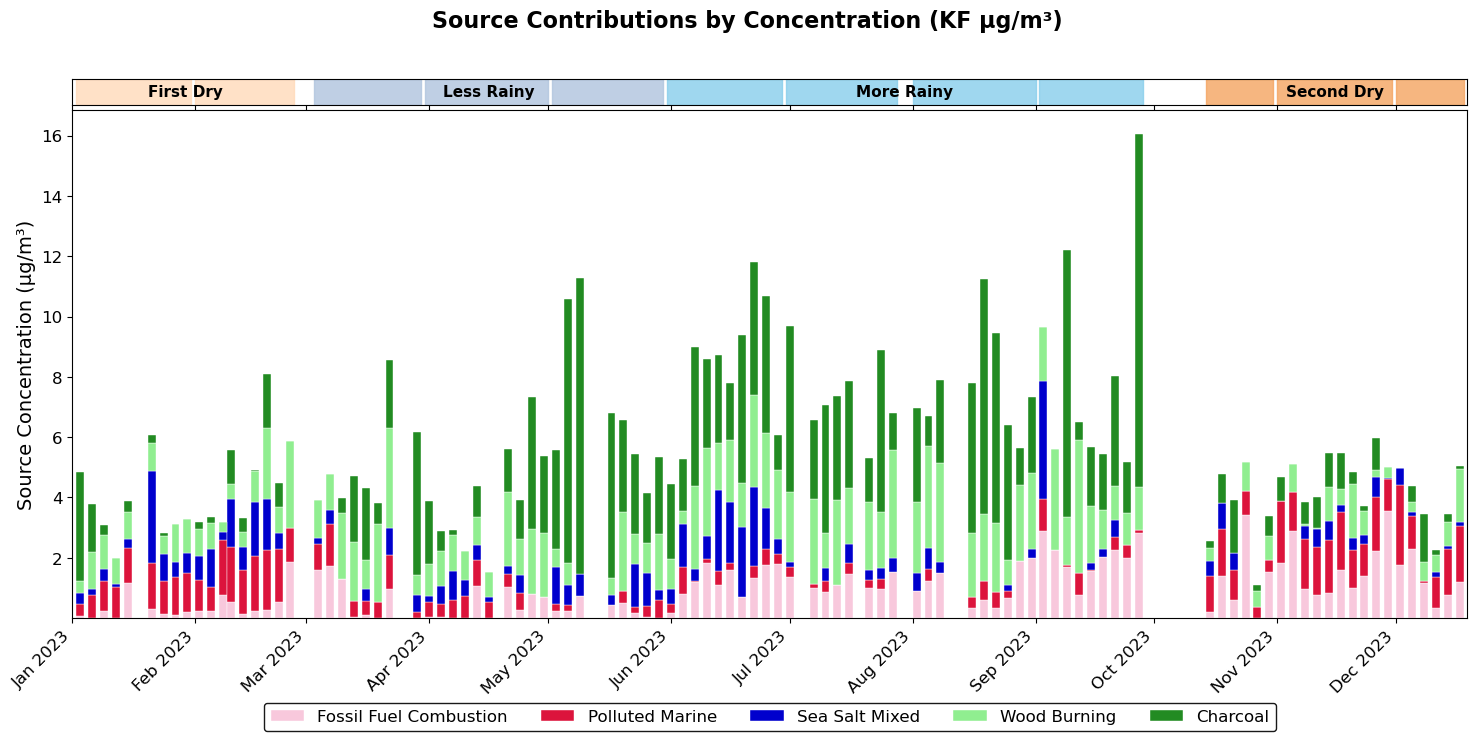


✓ FRIDAY SLIDE (a) — Concentration time series saved


In [120]:
# =============================================================================
# Source Contributions by Concentration (KF in µg/m³)
# =============================================================================

CONC_STACK_ORDER = [
    ('fossil_fuel_conc',    'Fossil Fuel Combustion', '#F8C8DC'),
    ('polluted_marine_conc','Polluted Marine',        '#DC143C'),
    ('sea_salt_conc',       'Sea Salt Mixed',         '#0000CD'),
    ('wood_conc',           'Wood Burning',           '#90EE90'),
    ('charcoal_conc',       'Charcoal',               '#228B22'),
]

conc_col_names = [col for col, _, _ in CONC_STACK_ORDER]
valid_conc = df.dropna(subset=[c for c in conc_col_names if c in df.columns]).copy()
valid_conc = valid_conc.sort_values('date').reset_index(drop=True)
valid_conc['season'] = valid_conc['Month'].apply(get_season)

print(f"Plotting {len(valid_conc)} samples")
print(f"Date range: {valid_conc['date'].min().date()} to {valid_conc['date'].max().date()}")

# --- Figure ---
fig, (ax_season, ax) = plt.subplots(
    2, 1, figsize=(18, 7),
    gridspec_kw={'height_ratios': [1, 20], 'hspace': 0.02},
    sharex=True
)

dates = valid_conc['date'].values
bar_width = 2.0
x_dates = mdates.date2num(dates)

bottom = np.zeros(len(valid_conc))
for col, label, color in CONC_STACK_ORDER:
    if col in valid_conc.columns:
        values = valid_conc[col].values
        ax.bar(x_dates, values, width=bar_width, bottom=bottom,
               color=color, label=label, edgecolor='white', linewidth=0.3)
        bottom += values

# Season strip
for name, months, color in SEASON_DEFS:
    for m in months:
        mask = valid_conc['Month'] == m
        if mask.any():
            m_dates = x_dates[mask]
            ax_season.axvspan(m_dates.min() - bar_width/2, m_dates.max() + bar_width/2,
                             color=color, alpha=0.8)

for name, months, color in SEASON_DEFS:
    mask = valid_conc['Month'].isin(months)
    if mask.any():
        m_dates = x_dates[mask]
        mid = (m_dates.min() + m_dates.max()) / 2
        ax_season.text(mid, 0.5, name, ha='center', va='center',
                      fontsize=FONT_CONFIG['annotation'], fontweight='bold',
                      transform=ax_season.get_xaxis_transform())

ax_season.set_yticks([])
date_min = x_dates.min() - bar_width
date_max = x_dates.max() + bar_width
ax_season.set_xlim(date_min, date_max)

# Title above everything
fig.suptitle('Source Contributions by Concentration (KF µg/m³)',
             fontsize=FONT_CONFIG['title'], fontweight='bold', y=0.98)

ax.set_ylabel('Source Concentration (µg/m³)', fontsize=FONT_CONFIG['axis_label'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=5, fontsize=FONT_CONFIG['legend'],
          framealpha=0.9, edgecolor='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(dirs['friday_slides'], 'source_concentration_timeseries.png'),
            dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ FRIDAY SLIDE (a) — Concentration time series saved")

---

# Section 3: Source Grouping — Combined vs Separate

**Ann's instruction**: Try both:
- **Combined**: charcoal + wood → biomass burning; fossil fuel + polluted marine → fossil fuel combustion
- **Separate**: Keep original 5 sources (minus sea salt)

**Exclude sea salt** (only 3 samples).

---

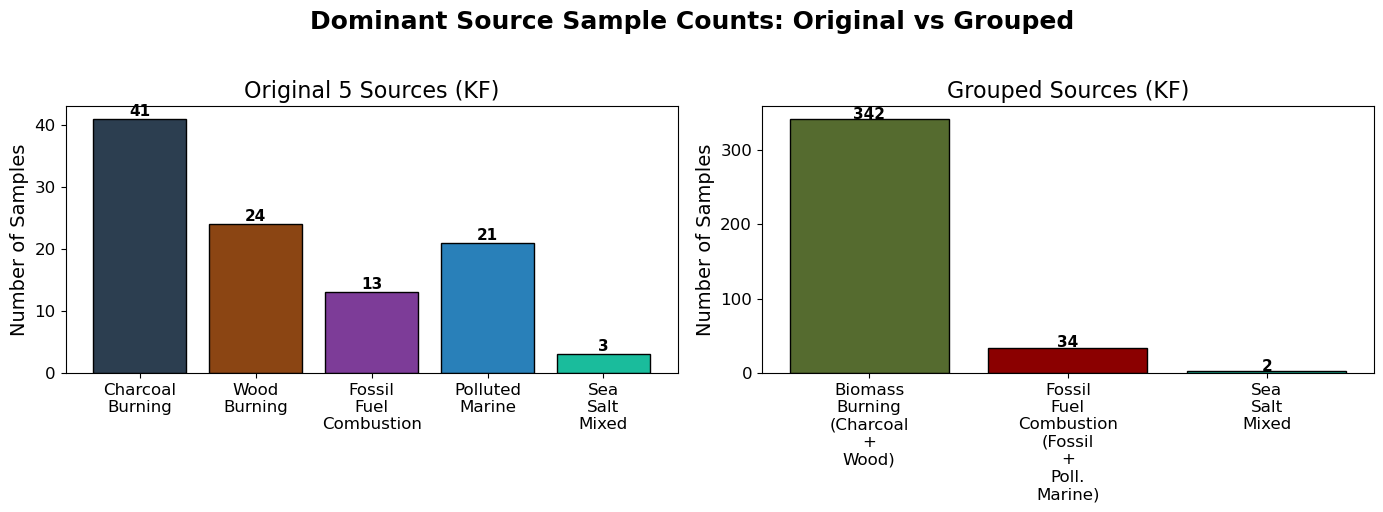

In [121]:
# =============================================================================
# Compare Grouped vs Original Source Distributions
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Original 5 sources
ax = axes[0]
source_counts = df['dominant_source'].value_counts().reindex(SOURCE_ORDER, fill_value=0)
colors = [SOURCE_CATEGORIES[s]['color'] for s in SOURCE_ORDER]
labels = [SOURCE_CATEGORIES[s]['label'] for s in SOURCE_ORDER]
bars = ax.bar(range(len(SOURCE_ORDER)), source_counts.values, color=colors, edgecolor='black')
ax.set_xticks(range(len(SOURCE_ORDER)))
ax.set_xticklabels([s.replace(' ', '\n') for s in labels], fontsize=FONT_CONFIG['tick'])
ax.set_ylabel('Number of Samples', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Original 5 Sources (KF)', fontsize=FONT_CONFIG['title'])
for bar, count in zip(bars, source_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', fontsize=FONT_CONFIG['annotation'], fontweight='bold')

# Panel 2: Grouped sources
ax = axes[1]
grouped_counts = df['dominant_source_grouped'].value_counts().reindex(GROUPED_SOURCE_ORDER, fill_value=0)
g_colors = [GROUPED_SOURCE_CATEGORIES[s]['color'] for s in GROUPED_SOURCE_ORDER]
g_labels = [GROUPED_SOURCE_CATEGORIES[s]['label'].replace('\n', ' ') for s in GROUPED_SOURCE_ORDER]
bars = ax.bar(range(len(GROUPED_SOURCE_ORDER)), grouped_counts.values, color=g_colors, edgecolor='black')
ax.set_xticks(range(len(GROUPED_SOURCE_ORDER)))
ax.set_xticklabels([s.replace(' ', '\n') for s in g_labels], fontsize=FONT_CONFIG['tick'])
ax.set_ylabel('Number of Samples', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Grouped Sources (KF)', fontsize=FONT_CONFIG['title'])
for bar, count in zip(bars, grouped_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', fontsize=FONT_CONFIG['annotation'], fontweight='bold')

plt.suptitle('Dominant Source Sample Counts: Original vs Grouped',
             fontsize=FONT_CONFIG['title'] + 2, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'source_grouping_comparison.png'),
            dpi=150, bbox_inches='tight')
plt.show()

---

# Section 4: Cross-Plots by Source Type with Slopes

**Friday Slide (b)**: Cross-plot showing slopes by source type  
**Expectation**: Different source types should show different slopes  
**Pairs**: HIPS vs FTIR EC, Aeth vs FTIR EC, Aeth vs HIPS  
**Run for**: Both original (separate) and grouped source categories  
**FTIR EC always on X-axis**

---

In [122]:
# =============================================================================
# Core Regression Plotting Function (with standardized styling)
# =============================================================================

def plot_regression(ax, x, y, color, marker, label, show_stats=True, xlim=None):
    """
    Plot scatter + regression line on given axes.
    If xlim is provided, the regression line spans that full range.
    Returns dict with slope, intercept, r2, n.
    """
    mask = np.isfinite(x) & np.isfinite(y)
    x_clean, y_clean = x[mask], y[mask]
    n = len(x_clean)
    
    if n < 3:
        ax.text(0.5, 0.5, f'{label}\nn={n} (insufficient)',
                transform=ax.transAxes, ha='center', va='center',
                fontsize=FONT_CONFIG['annotation'])
        return {'slope': np.nan, 'intercept': np.nan, 'r2': np.nan, 'n': n}
    
    ax.scatter(x_clean, y_clean, c=color, marker=marker, s=50, alpha=0.7,
              edgecolors='black', linewidths=0.5, label=label, zorder=3)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
    r2 = r_value**2
    
    # Extend regression line to full axis range if xlim provided
    if xlim is not None:
        x_line = np.linspace(xlim[0], xlim[1], 100)
    else:
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
    ax.plot(x_line, slope * x_line + intercept, color=color, linewidth=2, linestyle='-', zorder=2)
    
    if show_stats:
        sign = '+' if intercept >= 0 else '-'
        stats_text = f'y = {slope:.3f}x {sign} {abs(intercept):.3f}\nR² = {r2:.3f}\nn = {n}'
        ax.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                   fontsize=FONT_CONFIG['stats_box'], verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))
    
    return {'slope': slope, 'intercept': intercept, 'r2': r2, 'n': n, 'p': p_value}


def plot_all_sources_overlay(df_plot, x_col, y_col, x_label, y_label, title,
                              source_col, source_categories, source_order,
                              exclude_sea_salt=True):
    """
    Single cross-plot with all sources overlaid, each with its own regression line.
    This is the "slopes by source type" plot Ann requested for the Friday slide.
    """
    fig, ax = plt.subplots(figsize=(10, 9))
    
    # Compute axis limits first so regression lines can span the full range
    all_vals = np.concatenate([df_plot[x_col].dropna().values, df_plot[y_col].dropna().values])
    lims = [0, np.nanpercentile(all_vals, 99) * 1.1]
    
    results = {}
    legend_elements = []
    
    for source_key in source_order:
        if exclude_sea_salt and source_key == 'sea_salt':
            continue
        
        info = source_categories[source_key]
        mask = df_plot[source_col] == source_key
        subset = df_plot[mask]
        
        if len(subset) < 3:
            continue
        
        x = subset[x_col].values
        y = subset[y_col].values
        valid = np.isfinite(x) & np.isfinite(y)
        x_v, y_v = x[valid], y[valid]
        
        if len(x_v) < 3:
            continue
        
        ax.scatter(x_v, y_v, c=info['color'], marker=info['marker'],
                  s=60, alpha=0.7, edgecolors='black', linewidths=0.5, zorder=3)
        
        slope, intercept, r_value, _, _ = stats.linregress(x_v, y_v)
        r2 = r_value**2
        
        # Regression line spans full axis range
        x_line = np.linspace(lims[0], lims[1], 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color=info['color'],
               linewidth=2.5, linestyle='-', zorder=2)
        
        results[source_key] = {'slope': slope, 'intercept': intercept, 'r2': r2, 'n': len(x_v)}
        
        lbl = info['label'].replace('\n', ' ')
        sign = '+' if intercept >= 0 else '-'
        legend_elements.append(
            Line2D([0], [0], marker=info['marker'], color=info['color'],
                   markeredgecolor='black', markersize=8, linewidth=2,
                   label=f"{lbl}: y={slope:.2f}x {sign} {abs(intercept):.2f}, R²={r2:.2f} (n={len(x_v)})")
        )
    
    # 1:1 line
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1, label='1:1', zorder=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_xlabel(x_label, fontsize=FONT_CONFIG['axis_label'])
    ax.set_ylabel(y_label, fontsize=FONT_CONFIG['axis_label'])
    ax.set_title(title, fontsize=FONT_CONFIG['title'], fontweight='bold')
    ax.legend(handles=legend_elements, loc='upper left',
             fontsize=FONT_CONFIG['legend'] - 1, framealpha=0.9, edgecolor='black')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, results

print("Plotting functions defined")

Plotting functions defined


CROSS-PLOTS: SEPARATE SOURCES (Original 5, excl. sea salt)

--- hips_vs_ec: 378 samples with both measurements ---


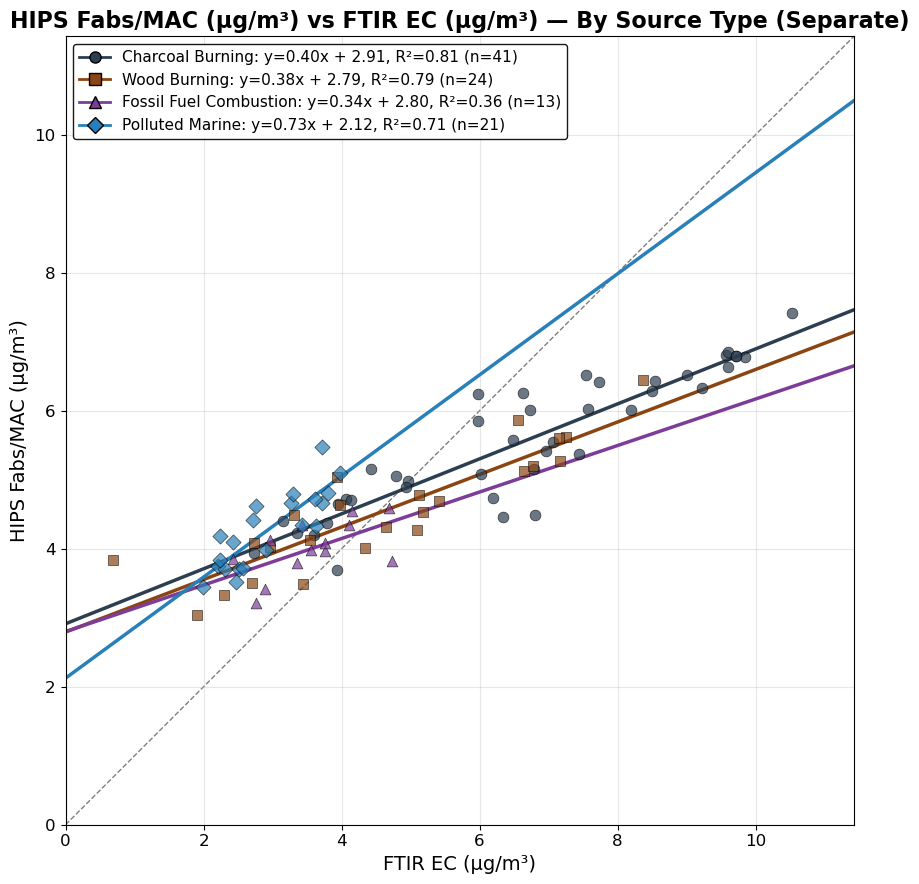


  Source                       Slope  Intercept       R²     n
  ------------------------------------------------------------
  Charcoal Burning             0.398      2.912    0.814    41
  Wood Burning                 0.381      2.792    0.786    24
  Fossil Fuel Combustion       0.337      2.799    0.357    13
  Polluted Marine              0.733      2.124    0.706    21

--- aeth_vs_ec: 360 samples with both measurements ---


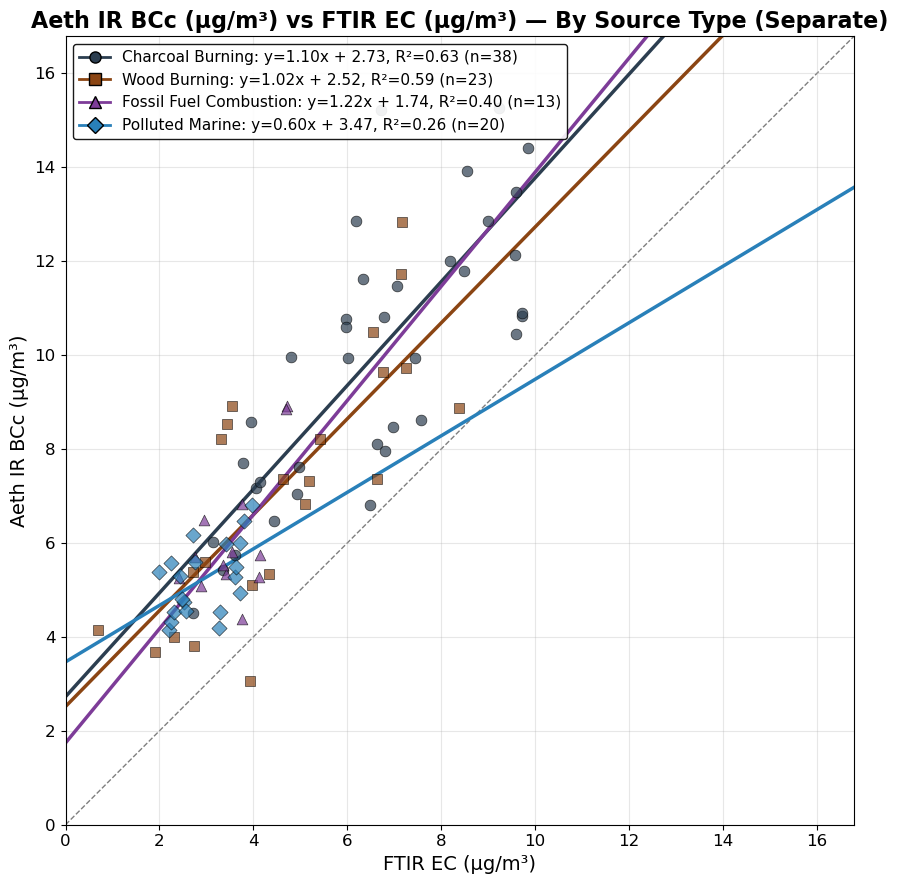


  Source                       Slope  Intercept       R²     n
  ------------------------------------------------------------
  Charcoal Burning             1.105      2.727    0.627    38
  Wood Burning                 1.021      2.517    0.594    23
  Fossil Fuel Combustion       1.215      1.742    0.397    13
  Polluted Marine              0.602      3.467    0.256    20

--- aeth_vs_hips: 360 samples with both measurements ---


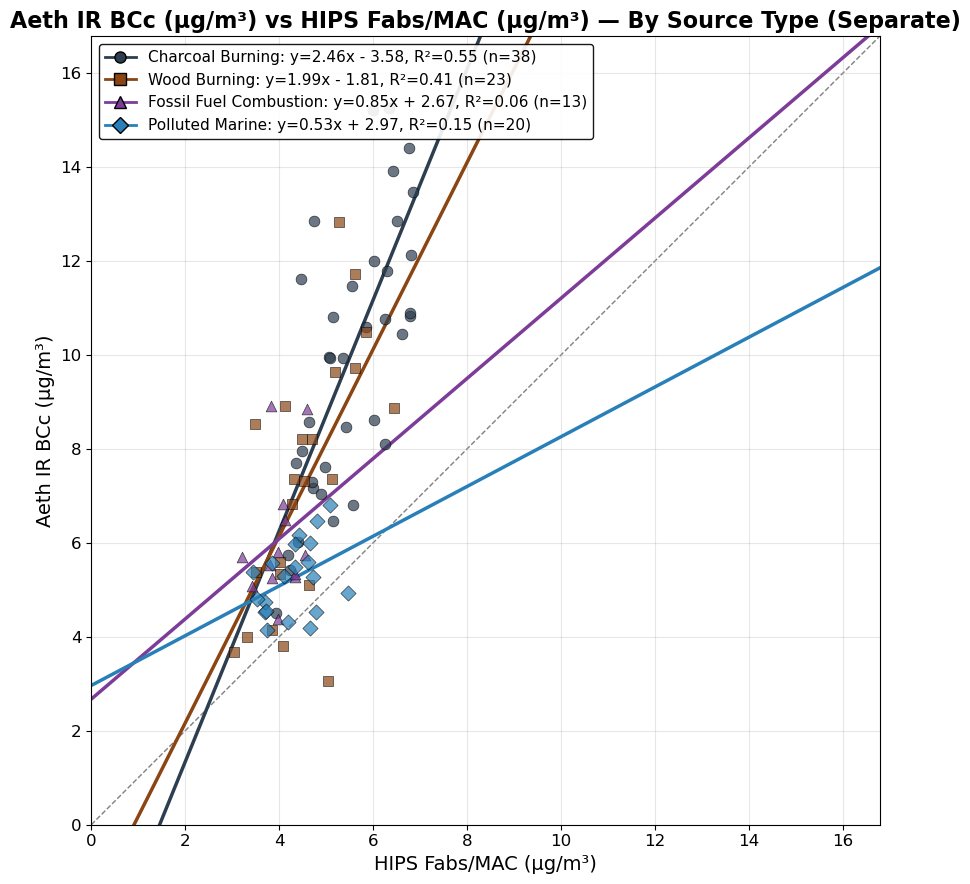


  Source                       Slope  Intercept       R²     n
  ------------------------------------------------------------
  Charcoal Burning             2.458     -3.579    0.549    38
  Wood Burning                 1.989     -1.812    0.414    23
  Fossil Fuel Combustion       0.853      2.675    0.062    13
  Polluted Marine              0.530      2.966    0.148    20

✓ FRIDAY SLIDE (b) — Separate source cross-plots saved


In [123]:
# =============================================================================
# 4A: Cross-Plots with SEPARATE Sources (original 5, excl. sea salt)
# =============================================================================

print("=" * 80)
print("CROSS-PLOTS: SEPARATE SOURCES (Original 5, excl. sea salt)")
print("=" * 80)

separate_results = {}

for x_col, y_col, x_label, y_label, pair_name in MEASUREMENT_PAIRS:
    valid_data = df.dropna(subset=[x_col, y_col])
    print(f"\n--- {pair_name}: {len(valid_data)} samples with both measurements ---")
    
    fig, results = plot_all_sources_overlay(
        valid_data, x_col, y_col, x_label, y_label,
        f'{y_label} vs {x_label} — By Source Type (Separate)',
        source_col='dominant_source',
        source_categories=SOURCE_CATEGORIES,
        source_order=SOURCE_ORDER,
        exclude_sea_salt=True
    )
    
    plt.savefig(os.path.join(dirs['friday_slides'], f'crossplot_separate_{pair_name}.png'),
                dpi=200, bbox_inches='tight')
    plt.show()
    
    separate_results[pair_name] = results
    
    # Print slope comparison table
    print(f"\n  {'Source':<25s} {'Slope':>8s} {'Intercept':>10s} {'R²':>8s} {'n':>5s}")
    print(f"  {'-'*60}")
    for source_key, res in results.items():
        lbl = SOURCE_CATEGORIES.get(source_key, {}).get('label', source_key)
        print(f"  {lbl:<25s} {res['slope']:8.3f} {res['intercept']:10.3f} {res['r2']:8.3f} {res['n']:5d}")

print("\n✓ FRIDAY SLIDE (b) — Separate source cross-plots saved")

CROSS-PLOTS: GROUPED SOURCES (Biomass Burning + Fossil Fuel Combustion)

--- hips_vs_ec: 378 samples ---


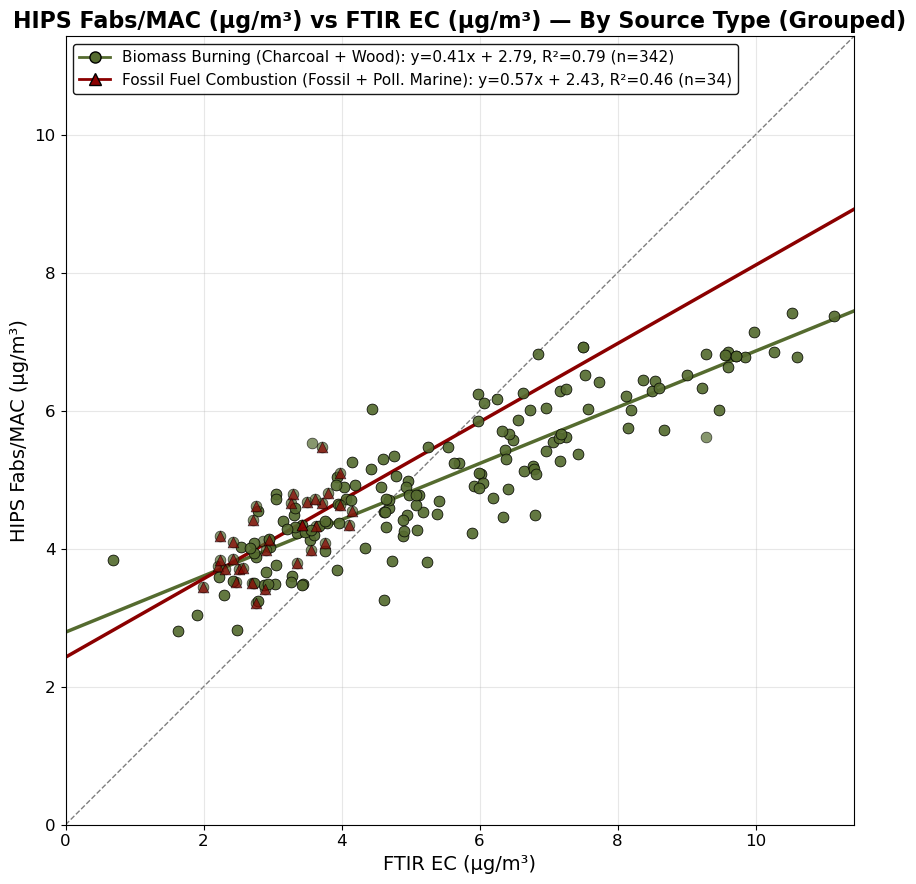


  Source                                      Slope  Intercept       R²     n
  ----------------------------------------------------------------------
  Biomass Burning (Charcoal + Wood)           0.407      2.791    0.789   342
  Fossil Fuel Combustion (Fossil + Poll. Marine)    0.568      2.427    0.462    34

--- aeth_vs_ec: 360 samples ---


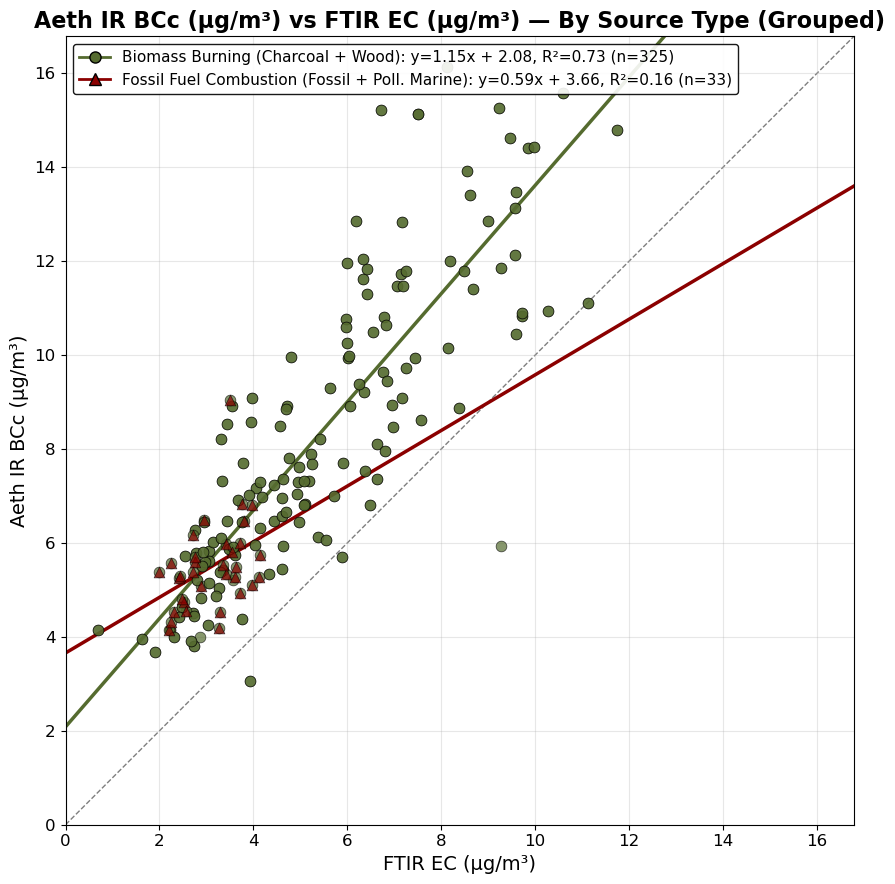


  Source                                      Slope  Intercept       R²     n
  ----------------------------------------------------------------------
  Biomass Burning (Charcoal + Wood)           1.153      2.085    0.734   325
  Fossil Fuel Combustion (Fossil + Poll. Marine)    0.592      3.657    0.161    33

--- aeth_vs_hips: 360 samples ---


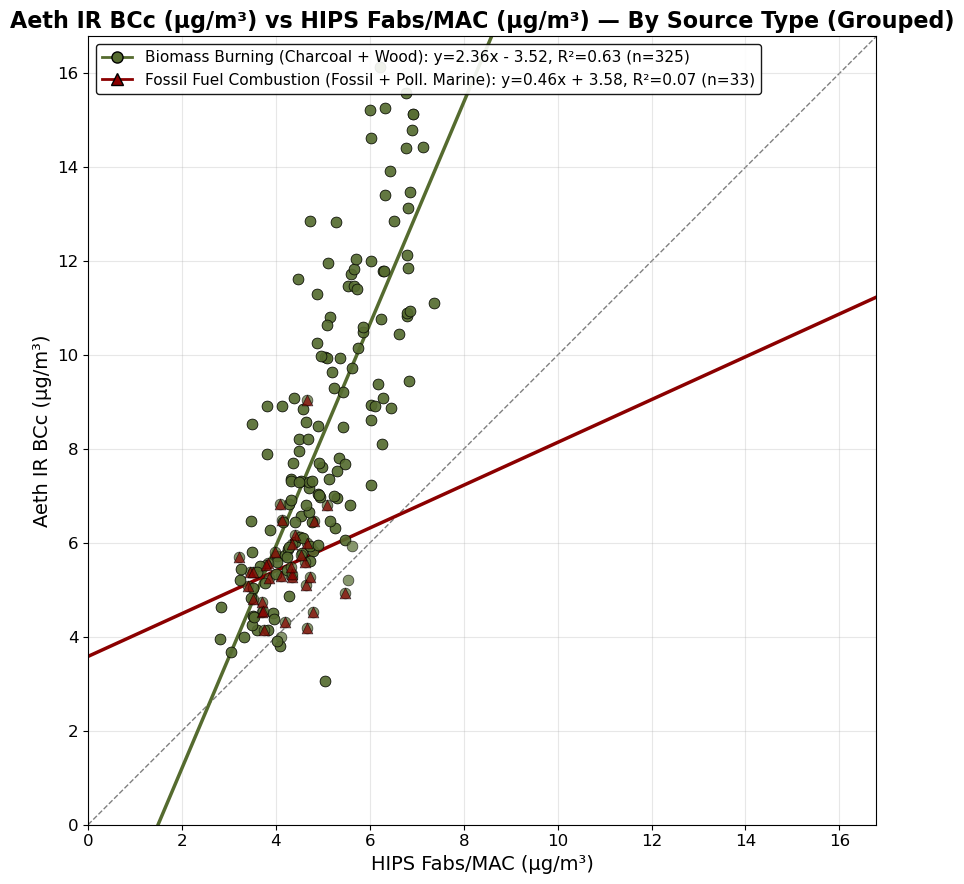


  Source                                      Slope  Intercept       R²     n
  ----------------------------------------------------------------------
  Biomass Burning (Charcoal + Wood)           2.364     -3.523    0.632   325
  Fossil Fuel Combustion (Fossil + Poll. Marine)    0.456      3.584    0.067    33

✓ Grouped source cross-plots saved


In [124]:
# =============================================================================
# 4B: Cross-Plots with GROUPED Sources (biomass + fossil fuel comb.)
# =============================================================================

print("=" * 80)
print("CROSS-PLOTS: GROUPED SOURCES (Biomass Burning + Fossil Fuel Combustion)")
print("=" * 80)

grouped_results = {}

for x_col, y_col, x_label, y_label, pair_name in MEASUREMENT_PAIRS:
    valid_data = df.dropna(subset=[x_col, y_col])
    print(f"\n--- {pair_name}: {len(valid_data)} samples ---")
    
    fig, results = plot_all_sources_overlay(
        valid_data, x_col, y_col, x_label, y_label,
        f'{y_label} vs {x_label} — By Source Type (Grouped)',
        source_col='dominant_source_grouped',
        source_categories=GROUPED_SOURCE_CATEGORIES,
        source_order=GROUPED_SOURCE_ORDER,
        exclude_sea_salt=True
    )
    
    plt.savefig(os.path.join(dirs['friday_slides'], f'crossplot_grouped_{pair_name}.png'),
                dpi=200, bbox_inches='tight')
    plt.show()
    
    grouped_results[pair_name] = results
    
    print(f"\n  {'Source':<40s} {'Slope':>8s} {'Intercept':>10s} {'R²':>8s} {'n':>5s}")
    print(f"  {'-'*70}")
    for source_key, res in results.items():
        lbl = GROUPED_SOURCE_CATEGORIES.get(source_key, {}).get('label', source_key).replace('\n', ' ')
        print(f"  {lbl:<40s} {res['slope']:8.3f} {res['intercept']:10.3f} {res['r2']:8.3f} {res['n']:5d}")

print("\n✓ Grouped source cross-plots saved")

In [125]:
# =============================================================================
# 4C: Slope Comparison Summary — Separate vs Grouped
# =============================================================================

print("=" * 80)
print("SLOPE COMPARISON: SEPARATE vs GROUPED")
print("=" * 80)

for pair_name in ['hips_vs_ec', 'aeth_vs_ec', 'aeth_vs_hips']:
    print(f"\n--- {pair_name.replace('_', ' ').upper()} ---")
    
    sep = separate_results.get(pair_name, {})
    grp = grouped_results.get(pair_name, {})
    
    # Also compute overall regression for comparison
    x_col = [p[0] for p in MEASUREMENT_PAIRS if p[4] == pair_name][0]
    y_col = [p[1] for p in MEASUREMENT_PAIRS if p[4] == pair_name][0]
    valid = df[[x_col, y_col]].dropna()
    if len(valid) >= 3:
        overall_slope, overall_int, r, _, _ = stats.linregress(valid[x_col], valid[y_col])
        print(f"  Overall: slope={overall_slope:.3f}, intercept={overall_int:.3f}, R²={r**2:.3f}, n={len(valid)}")
    
    print(f"\n  Separate sources:")
    for k, v in sep.items():
        lbl = SOURCE_CATEGORIES.get(k, {}).get('label', k)
        print(f"    {lbl:<25s}  slope={v['slope']:.3f}  R²={v['r2']:.3f}  n={v['n']}")
    
    print(f"\n  Grouped sources:")
    for k, v in grp.items():
        lbl = GROUPED_SOURCE_CATEGORIES.get(k, {}).get('label', k).replace('\n', ' ')
        print(f"    {lbl:<40s}  slope={v['slope']:.3f}  R²={v['r2']:.3f}  n={v['n']}")

SLOPE COMPARISON: SEPARATE vs GROUPED

--- HIPS VS EC ---
  Overall: slope=0.403, intercept=2.830, R²=0.785, n=378

  Separate sources:
    Charcoal Burning           slope=0.398  R²=0.814  n=41
    Wood Burning               slope=0.381  R²=0.786  n=24
    Fossil Fuel Combustion     slope=0.337  R²=0.357  n=13
    Polluted Marine            slope=0.733  R²=0.706  n=21

  Grouped sources:
    Biomass Burning (Charcoal + Wood)         slope=0.407  R²=0.789  n=342
    Fossil Fuel Combustion (Fossil + Poll. Marine)  slope=0.568  R²=0.462  n=34

--- AETH VS EC ---
  Overall: slope=1.157, intercept=2.041, R²=0.745, n=360

  Separate sources:
    Charcoal Burning           slope=1.105  R²=0.627  n=38
    Wood Burning               slope=1.021  R²=0.594  n=23
    Fossil Fuel Combustion     slope=1.215  R²=0.397  n=13
    Polluted Marine            slope=0.602  R²=0.256  n=20

  Grouped sources:
    Biomass Burning (Charcoal + Wood)         slope=1.153  R²=0.734  n=325
    Fossil Fuel Combusti

PER-SOURCE REGRESSION PANELS


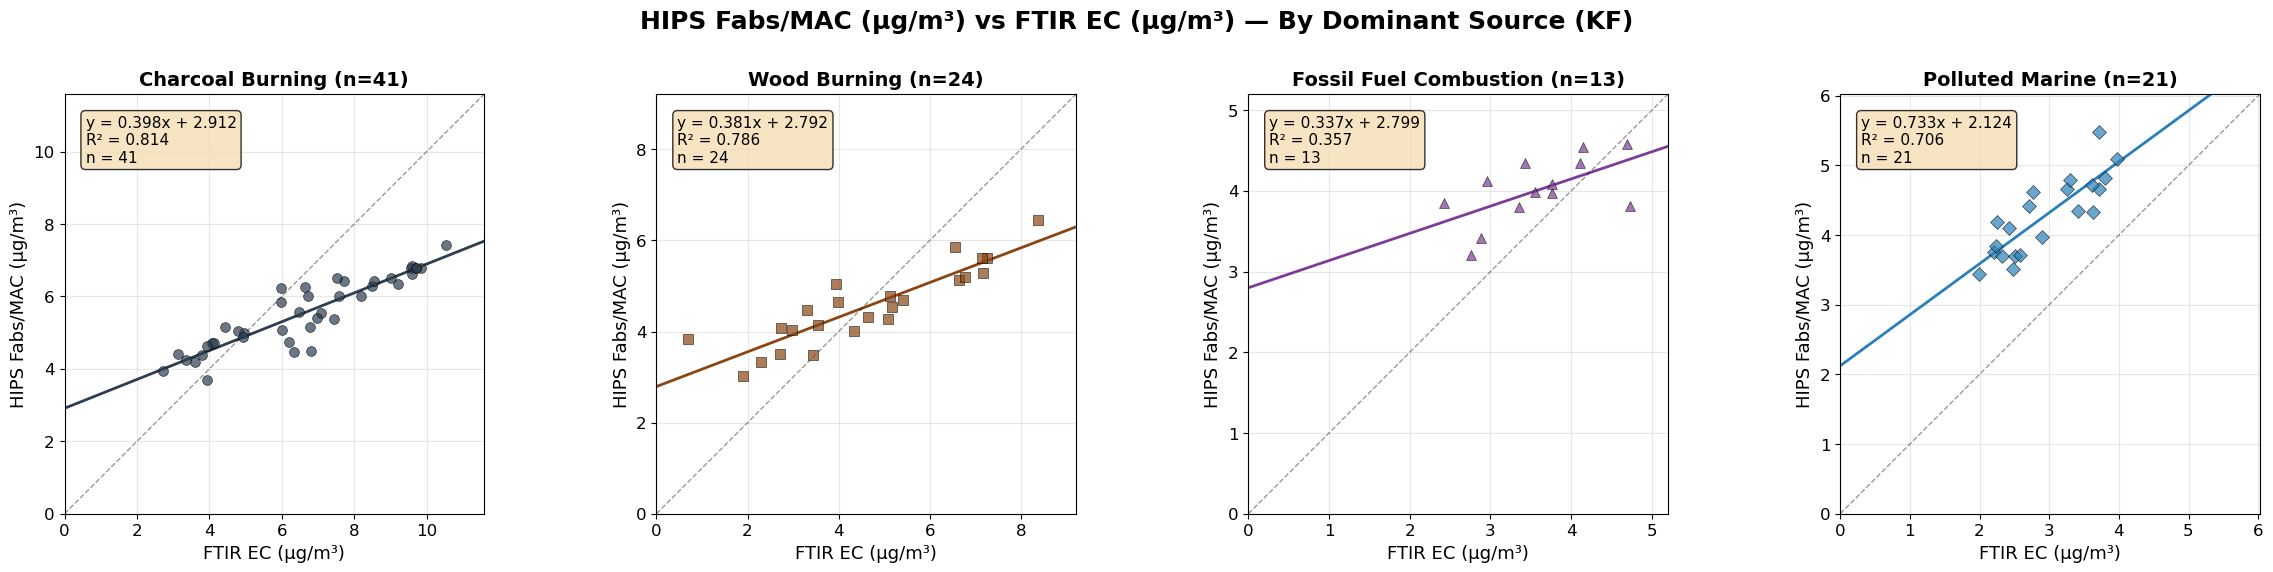

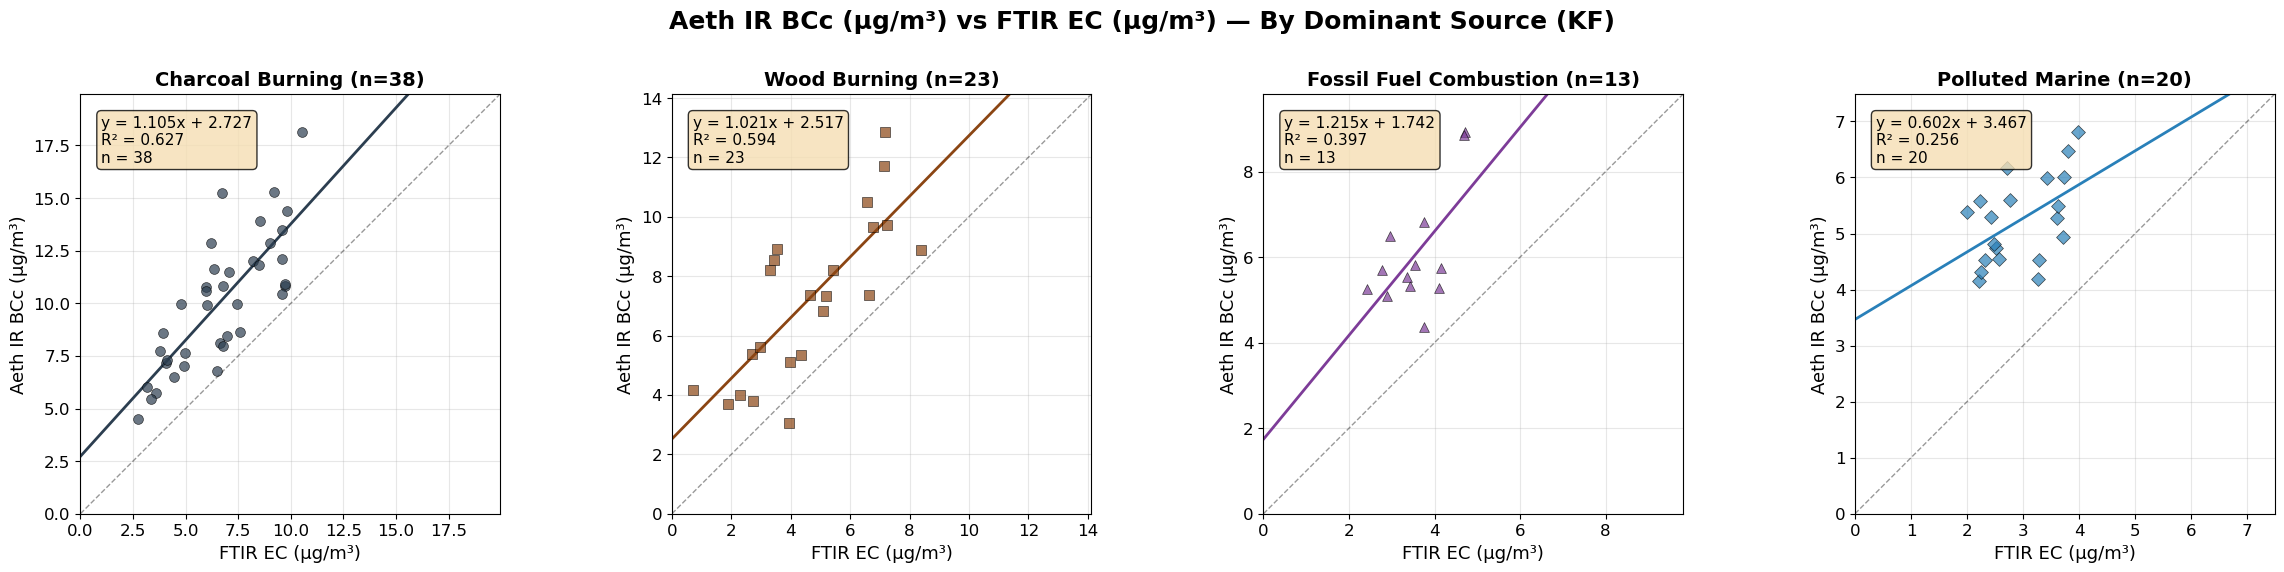

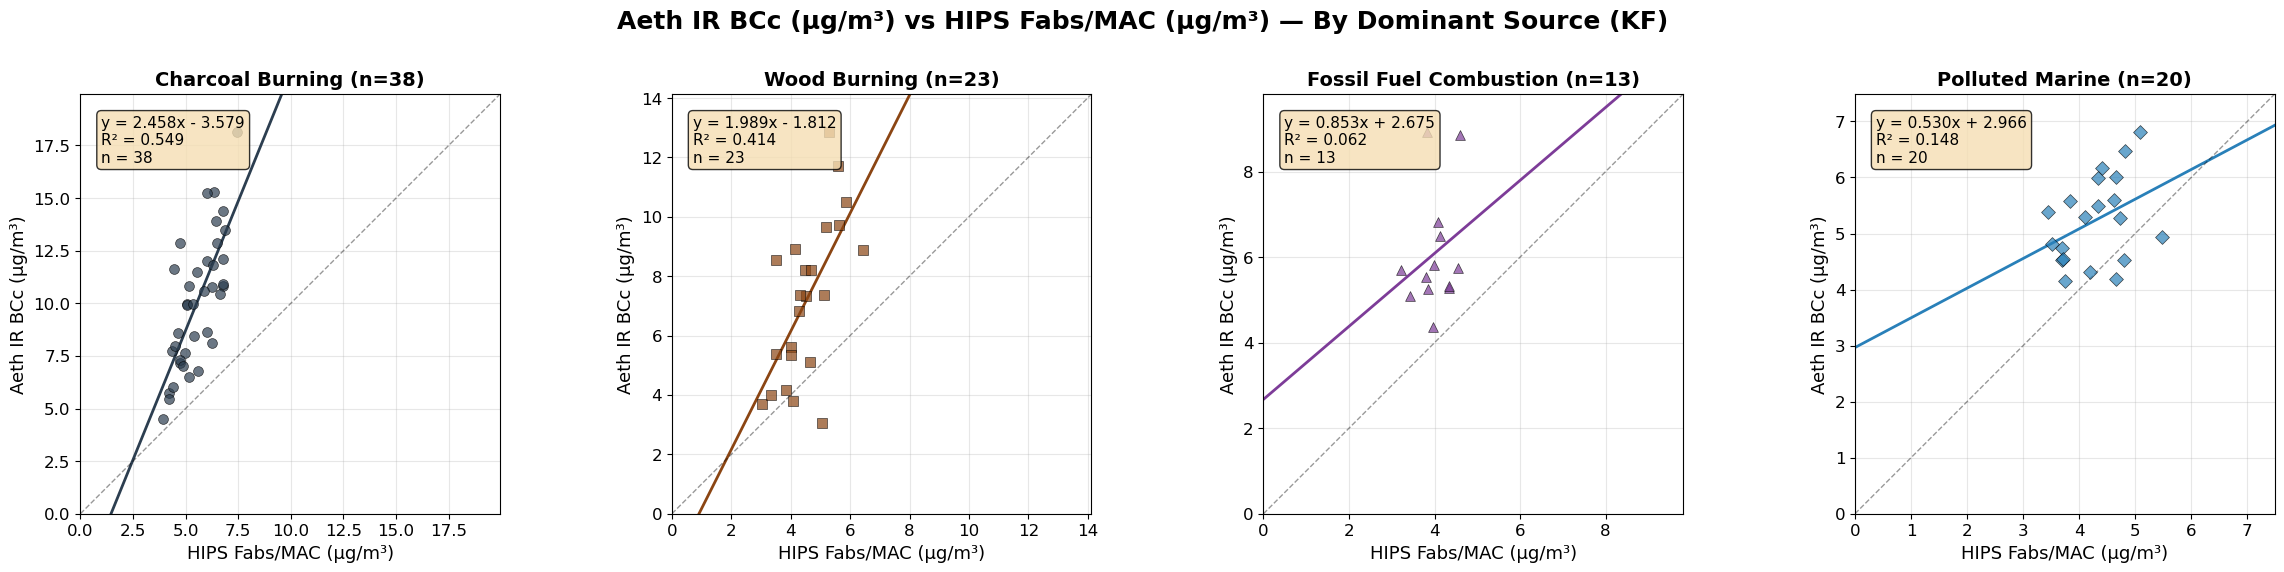

In [126]:
# =============================================================================
# 4D: Per-Source Regression Panels (5 separate plots)
# From Ahmad's original list: "Create 5 separate regression plots by source type"
# =============================================================================

print("=" * 80)
print("PER-SOURCE REGRESSION PANELS")
print("=" * 80)

for x_col, y_col, x_label, y_label, pair_name in MEASUREMENT_PAIRS:
    sources_to_plot = [s for s in SOURCE_ORDER if s != 'sea_salt']
    n_sources = len(sources_to_plot)
    n_cols = min(n_sources, 4)
    n_rows = int(np.ceil(n_sources / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5.5*n_rows))
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for idx, source in enumerate(sources_to_plot):
        ax = axes_flat[idx]
        info = SOURCE_CATEGORIES[source]
        
        mask = df['dominant_source'] == source
        subset = df[mask].dropna(subset=[x_col, y_col])
        
        # Compute axis limit first
        all_v = np.concatenate([subset[x_col].dropna().values, subset[y_col].dropna().values])
        lim = max(all_v) * 1.1 if len(all_v) > 0 else 1
        
        res = plot_regression(
            ax, subset[x_col].values, subset[y_col].values,
            info['color'], info['marker'], info['label'],
            xlim=(0, lim)
        )
        
        # 1:1 line
        if len(all_v) > 0:
            ax.plot([0, lim], [0, lim], 'k--', alpha=0.4, linewidth=1)
            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)
        
        ax.set_xlabel(x_label, fontsize=FONT_CONFIG['axis_label'] - 1)
        ax.set_ylabel(y_label, fontsize=FONT_CONFIG['axis_label'] - 1)
        ax.set_title(f"{info['label']} (n={len(subset)})",
                    fontsize=FONT_CONFIG['title'] - 2, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3)
    
    # Hide unused axes
    for idx in range(n_sources, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.suptitle(f'{y_label} vs {x_label} — By Dominant Source (KF)',
                fontsize=FONT_CONFIG['title'] + 2, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], f'per_source_panels_{pair_name}.png'),
                dpi=150, bbox_inches='tight')
    plt.show()

---

# Section 5: Threshold Analysis with Grouped Categories

**Task**: Repeat threshold analysis (30%, 40%, 50%, 60% dominance) with grouped categories  
**Both**: Original separate sources AND grouped sources

---

In [127]:
# =============================================================================
# Threshold Sample Count Tables
# =============================================================================

for config_name, src_col, frac_col, src_order, src_cats in [
    ('Separate Sources (KF)', 'dominant_source', 'dominant_fraction',
     [s for s in SOURCE_ORDER if s != 'sea_salt'], SOURCE_CATEGORIES),
    ('Grouped Sources (KF)', 'dominant_source_grouped', 'dominant_fraction_grouped',
     [s for s in GROUPED_SOURCE_ORDER if s != 'sea_salt'], GROUPED_SOURCE_CATEGORIES),
]:
    print(f"\n{'=' * 80}")
    print(f"Threshold Filtering: {config_name}")
    print(f"{'=' * 80}")
    
    header = f"{'Threshold':<12s}"
    for source in src_order:
        lbl = src_cats[source]['label'].replace('\n', ' ')[:15]
        header += f" {lbl:>15s}"
    header += f" {'Total':>8s}"
    print(header)
    print("-" * len(header))
    
    # No threshold
    row = f"{'All':<12s}"
    total = 0
    for source in src_order:
        n = (df[src_col] == source).sum()
        row += f" {n:15d}"
        total += n
    row += f" {total:8d}"
    print(row)
    
    for thresh in DOMINANCE_THRESHOLDS:
        filtered = df[df[frac_col] >= thresh]
        row = f"{thresh*100:.0f}%{'':<9s}"
        total = 0
        for source in src_order:
            n = (filtered[src_col] == source).sum()
            row += f" {n:15d}"
            total += n
        row += f" {total:8d}"
        print(row)


Threshold Filtering: Separate Sources (KF)
Threshold    Charcoal Burnin    Wood Burning Fossil Fuel Com Polluted Marine    Total
-------------------------------------------------------------------------------------
All                       41              24              13              21       99
30%                       41              22              12              21       96
40%                       34              16               6              10       66
50%                       21               7               4               3       35
60%                       13               2               2               0       17

Threshold Filtering: Grouped Sources (KF)
Threshold    Biomass Burning Fossil Fuel Com    Total
-----------------------------------------------------
All                      342              34      376
30%                       66              34      100
40%                       66              33       99
50%                       60             

THRESHOLD ANALYSIS: GROUPED SOURCES

────────────────────────────────────────────────────────────
HIPS_VS_EC
────────────────────────────────────────────────────────────


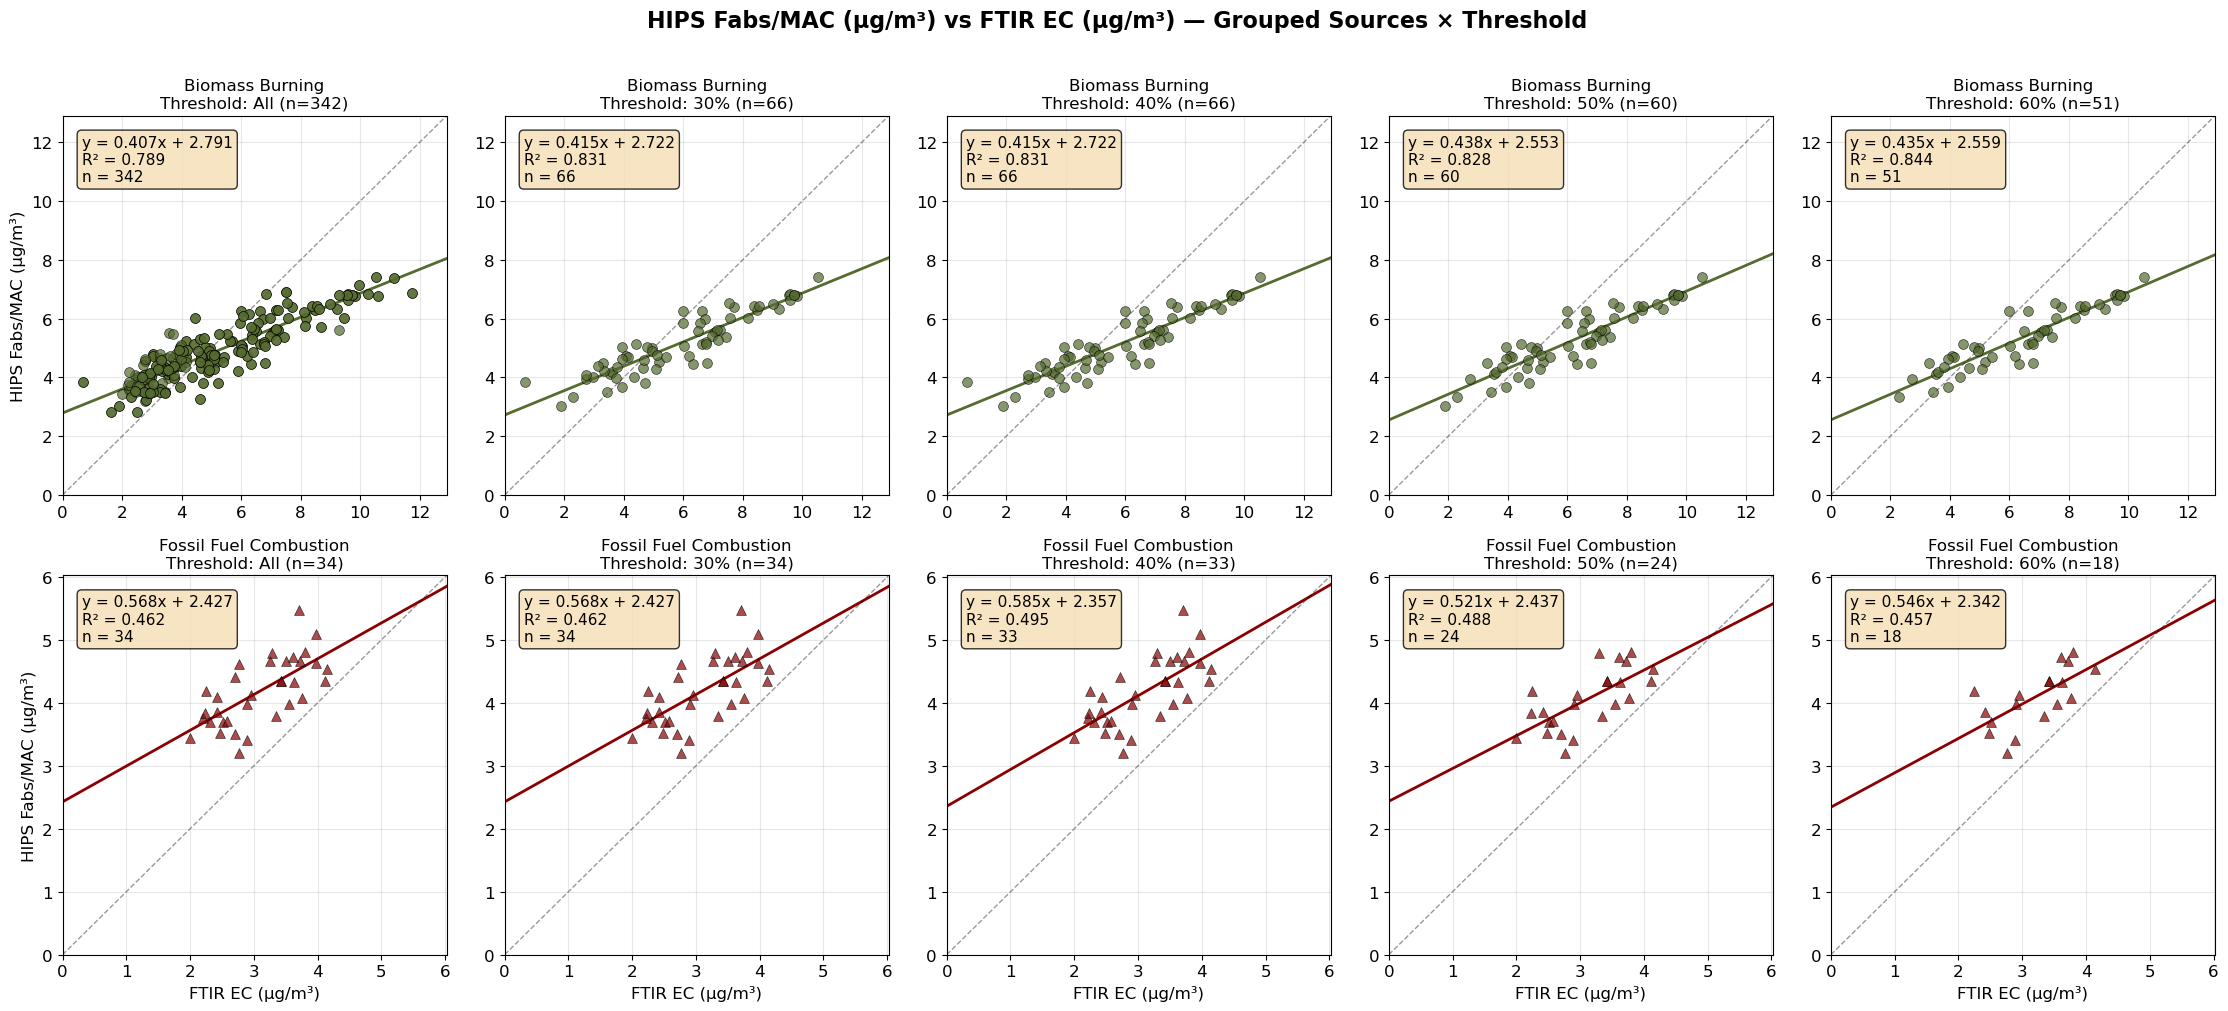


────────────────────────────────────────────────────────────
AETH_VS_EC
────────────────────────────────────────────────────────────


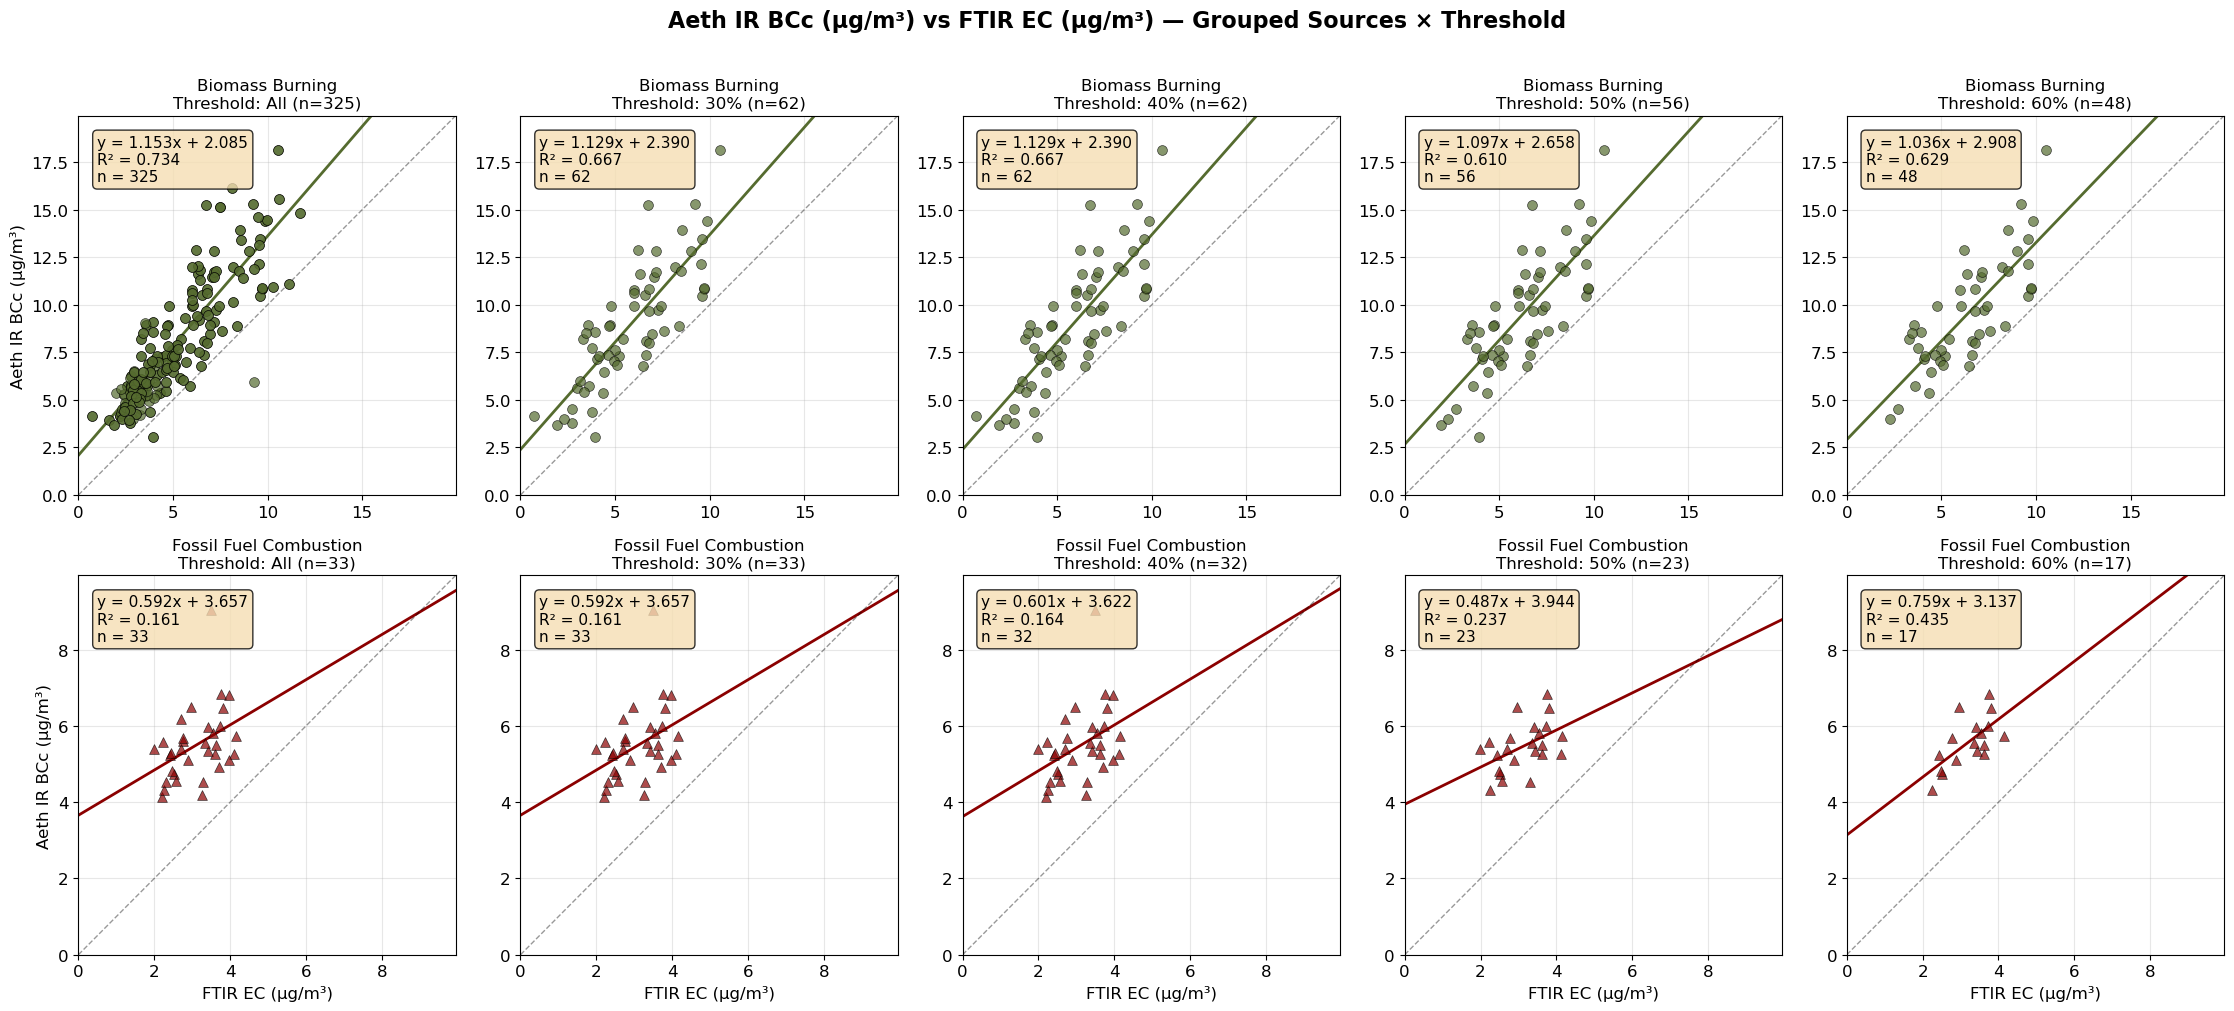


────────────────────────────────────────────────────────────
AETH_VS_HIPS
────────────────────────────────────────────────────────────


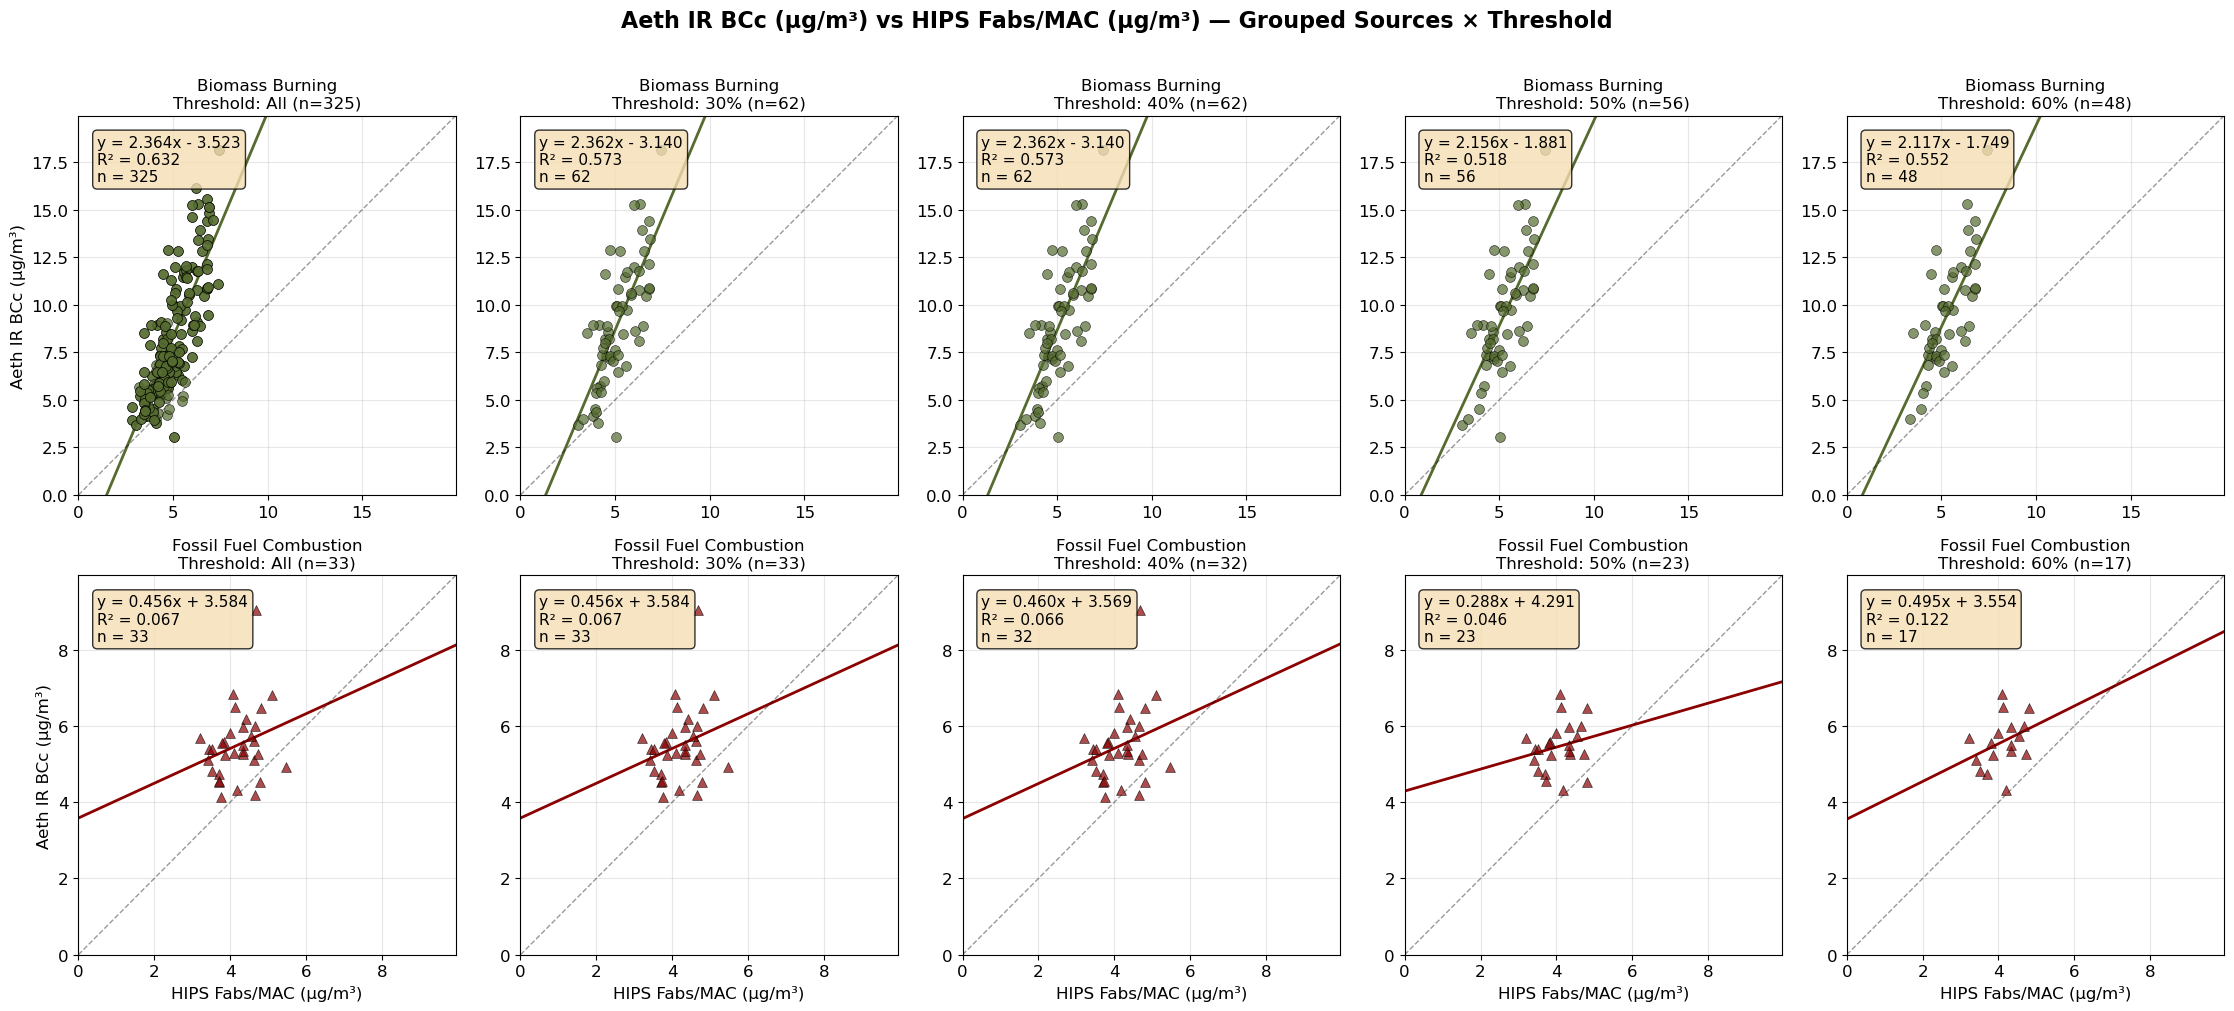

In [128]:
# =============================================================================
# Threshold-Filtered Cross-Plots: GROUPED Sources
# =============================================================================

print("=" * 80)
print("THRESHOLD ANALYSIS: GROUPED SOURCES")
print("=" * 80)

threshold_results_grouped = {}

for x_col, y_col, x_label, y_label, pair_name in MEASUREMENT_PAIRS:
    print(f"\n{'─' * 60}")
    print(f"{pair_name.upper()}")
    print(f"{'─' * 60}")
    
    thresholds = [None] + DOMINANCE_THRESHOLDS
    n_cols = len(thresholds)
    sources_to_plot = [s for s in GROUPED_SOURCE_ORDER if s != 'sea_salt']
    n_rows = len(sources_to_plot)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 5*n_rows))
    
    pair_results = {}
    
    for row_idx, source in enumerate(sources_to_plot):
        info = GROUPED_SOURCE_CATEGORIES[source]
        
        # Compute axis limit across all thresholds for this source
        all_source_mask = df['dominant_source_grouped'] == source
        all_source_data = df[all_source_mask].dropna(subset=[x_col, y_col])
        all_v_source = np.concatenate([all_source_data[x_col].values, all_source_data[y_col].values])
        row_lim = max(all_v_source) * 1.1 if len(all_v_source) > 0 else 1
        
        for col_idx, thresh in enumerate(thresholds):
            ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]
            
            mask = df['dominant_source_grouped'] == source
            if thresh is not None:
                mask = mask & (df['dominant_fraction_grouped'] >= thresh)
            
            subset = df[mask].dropna(subset=[x_col, y_col])
            
            res = plot_regression(
                ax, subset[x_col].values, subset[y_col].values,
                info['color'], info['marker'], info['label'].replace('\n', ' '),
                xlim=(0, row_lim)
            )
            
            thresh_label = 'All' if thresh is None else f'{thresh*100:.0f}%'
            ax.set_title(f"{info['label'].split(chr(10))[0]}\nThreshold: {thresh_label} (n={res['n']})",
                        fontsize=FONT_CONFIG['tick'])
            
            if col_idx == 0:
                ax.set_ylabel(y_label, fontsize=FONT_CONFIG['tick'])
            if row_idx == n_rows - 1:
                ax.set_xlabel(x_label, fontsize=FONT_CONFIG['tick'])
            
            ax.grid(True, alpha=0.3)
            
            # 1:1 line and consistent axis limits
            ax.plot([0, row_lim], [0, row_lim], 'k--', alpha=0.4, linewidth=1)
            ax.set_xlim(0, row_lim)
            ax.set_ylim(0, row_lim)
            
            pair_results[(source, thresh_label)] = res
    
    plt.suptitle(f'{y_label} vs {x_label} — Grouped Sources × Threshold',
                fontsize=FONT_CONFIG['title'], fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], f'threshold_grouped_{pair_name}.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    
    threshold_results_grouped[pair_name] = pair_results

THRESHOLD ANALYSIS: SEPARATE SOURCES

────────────────────────────────────────────────────────────
HIPS_VS_EC
────────────────────────────────────────────────────────────


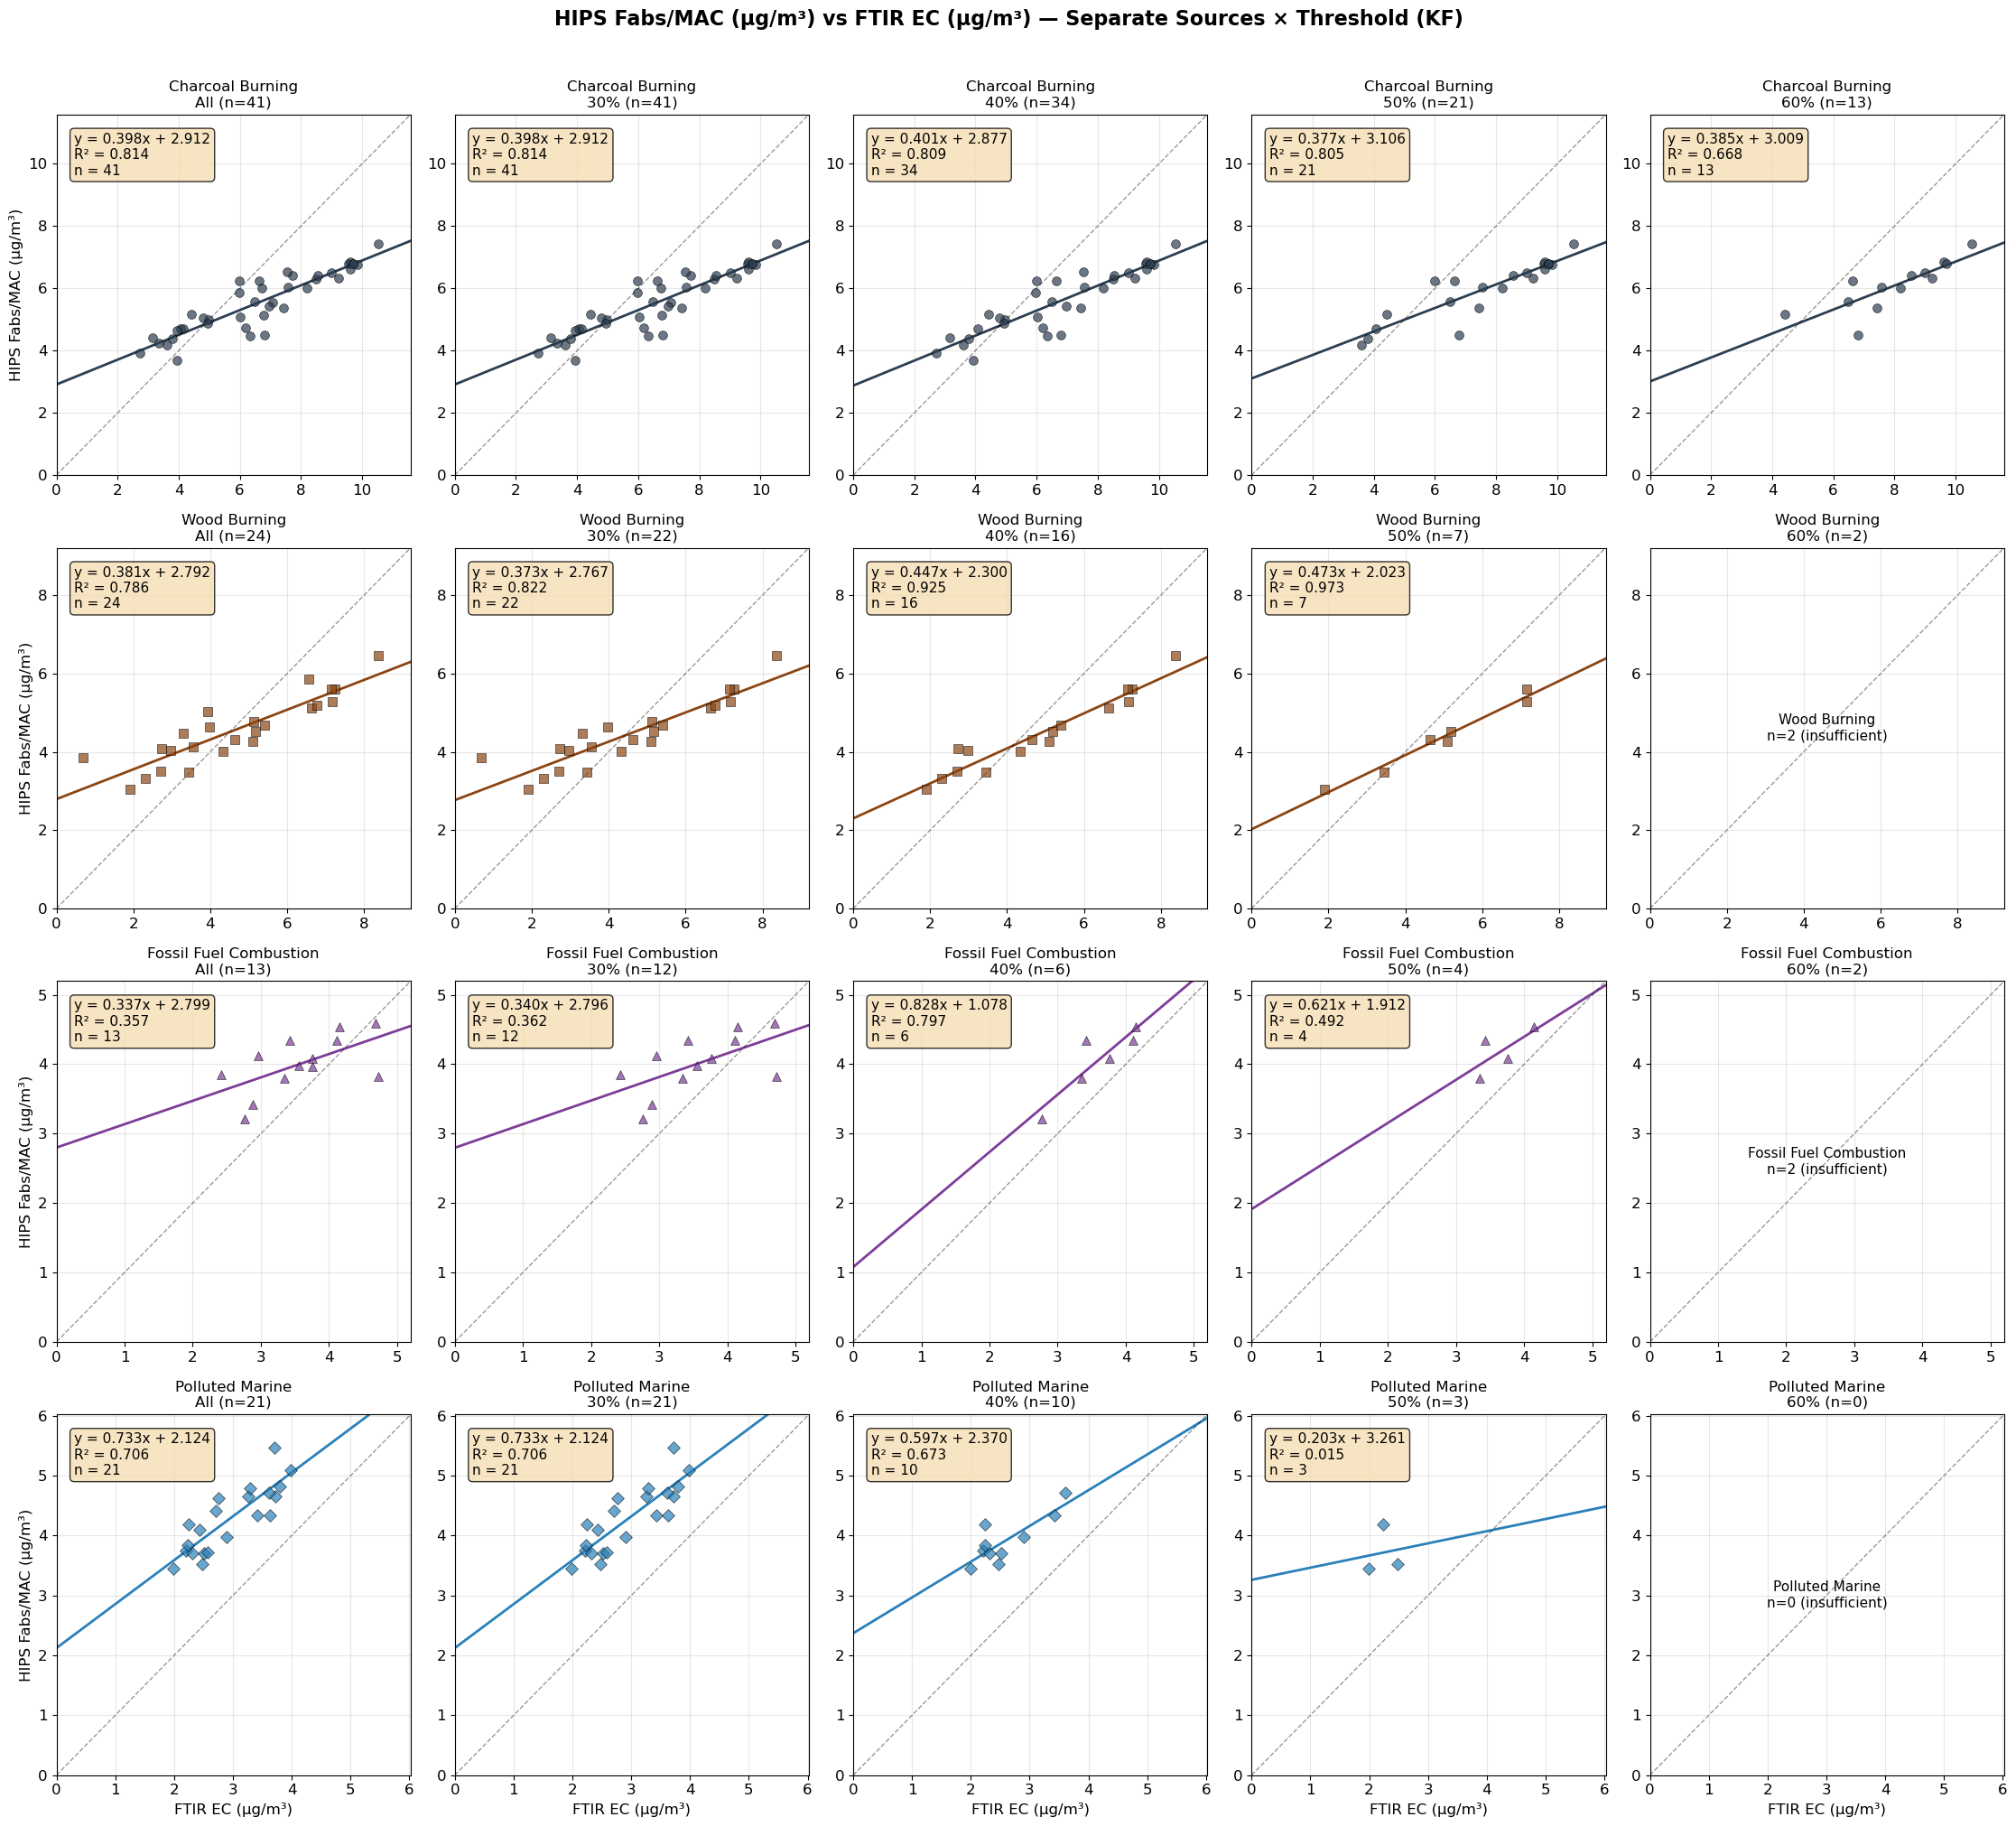


────────────────────────────────────────────────────────────
AETH_VS_EC
────────────────────────────────────────────────────────────


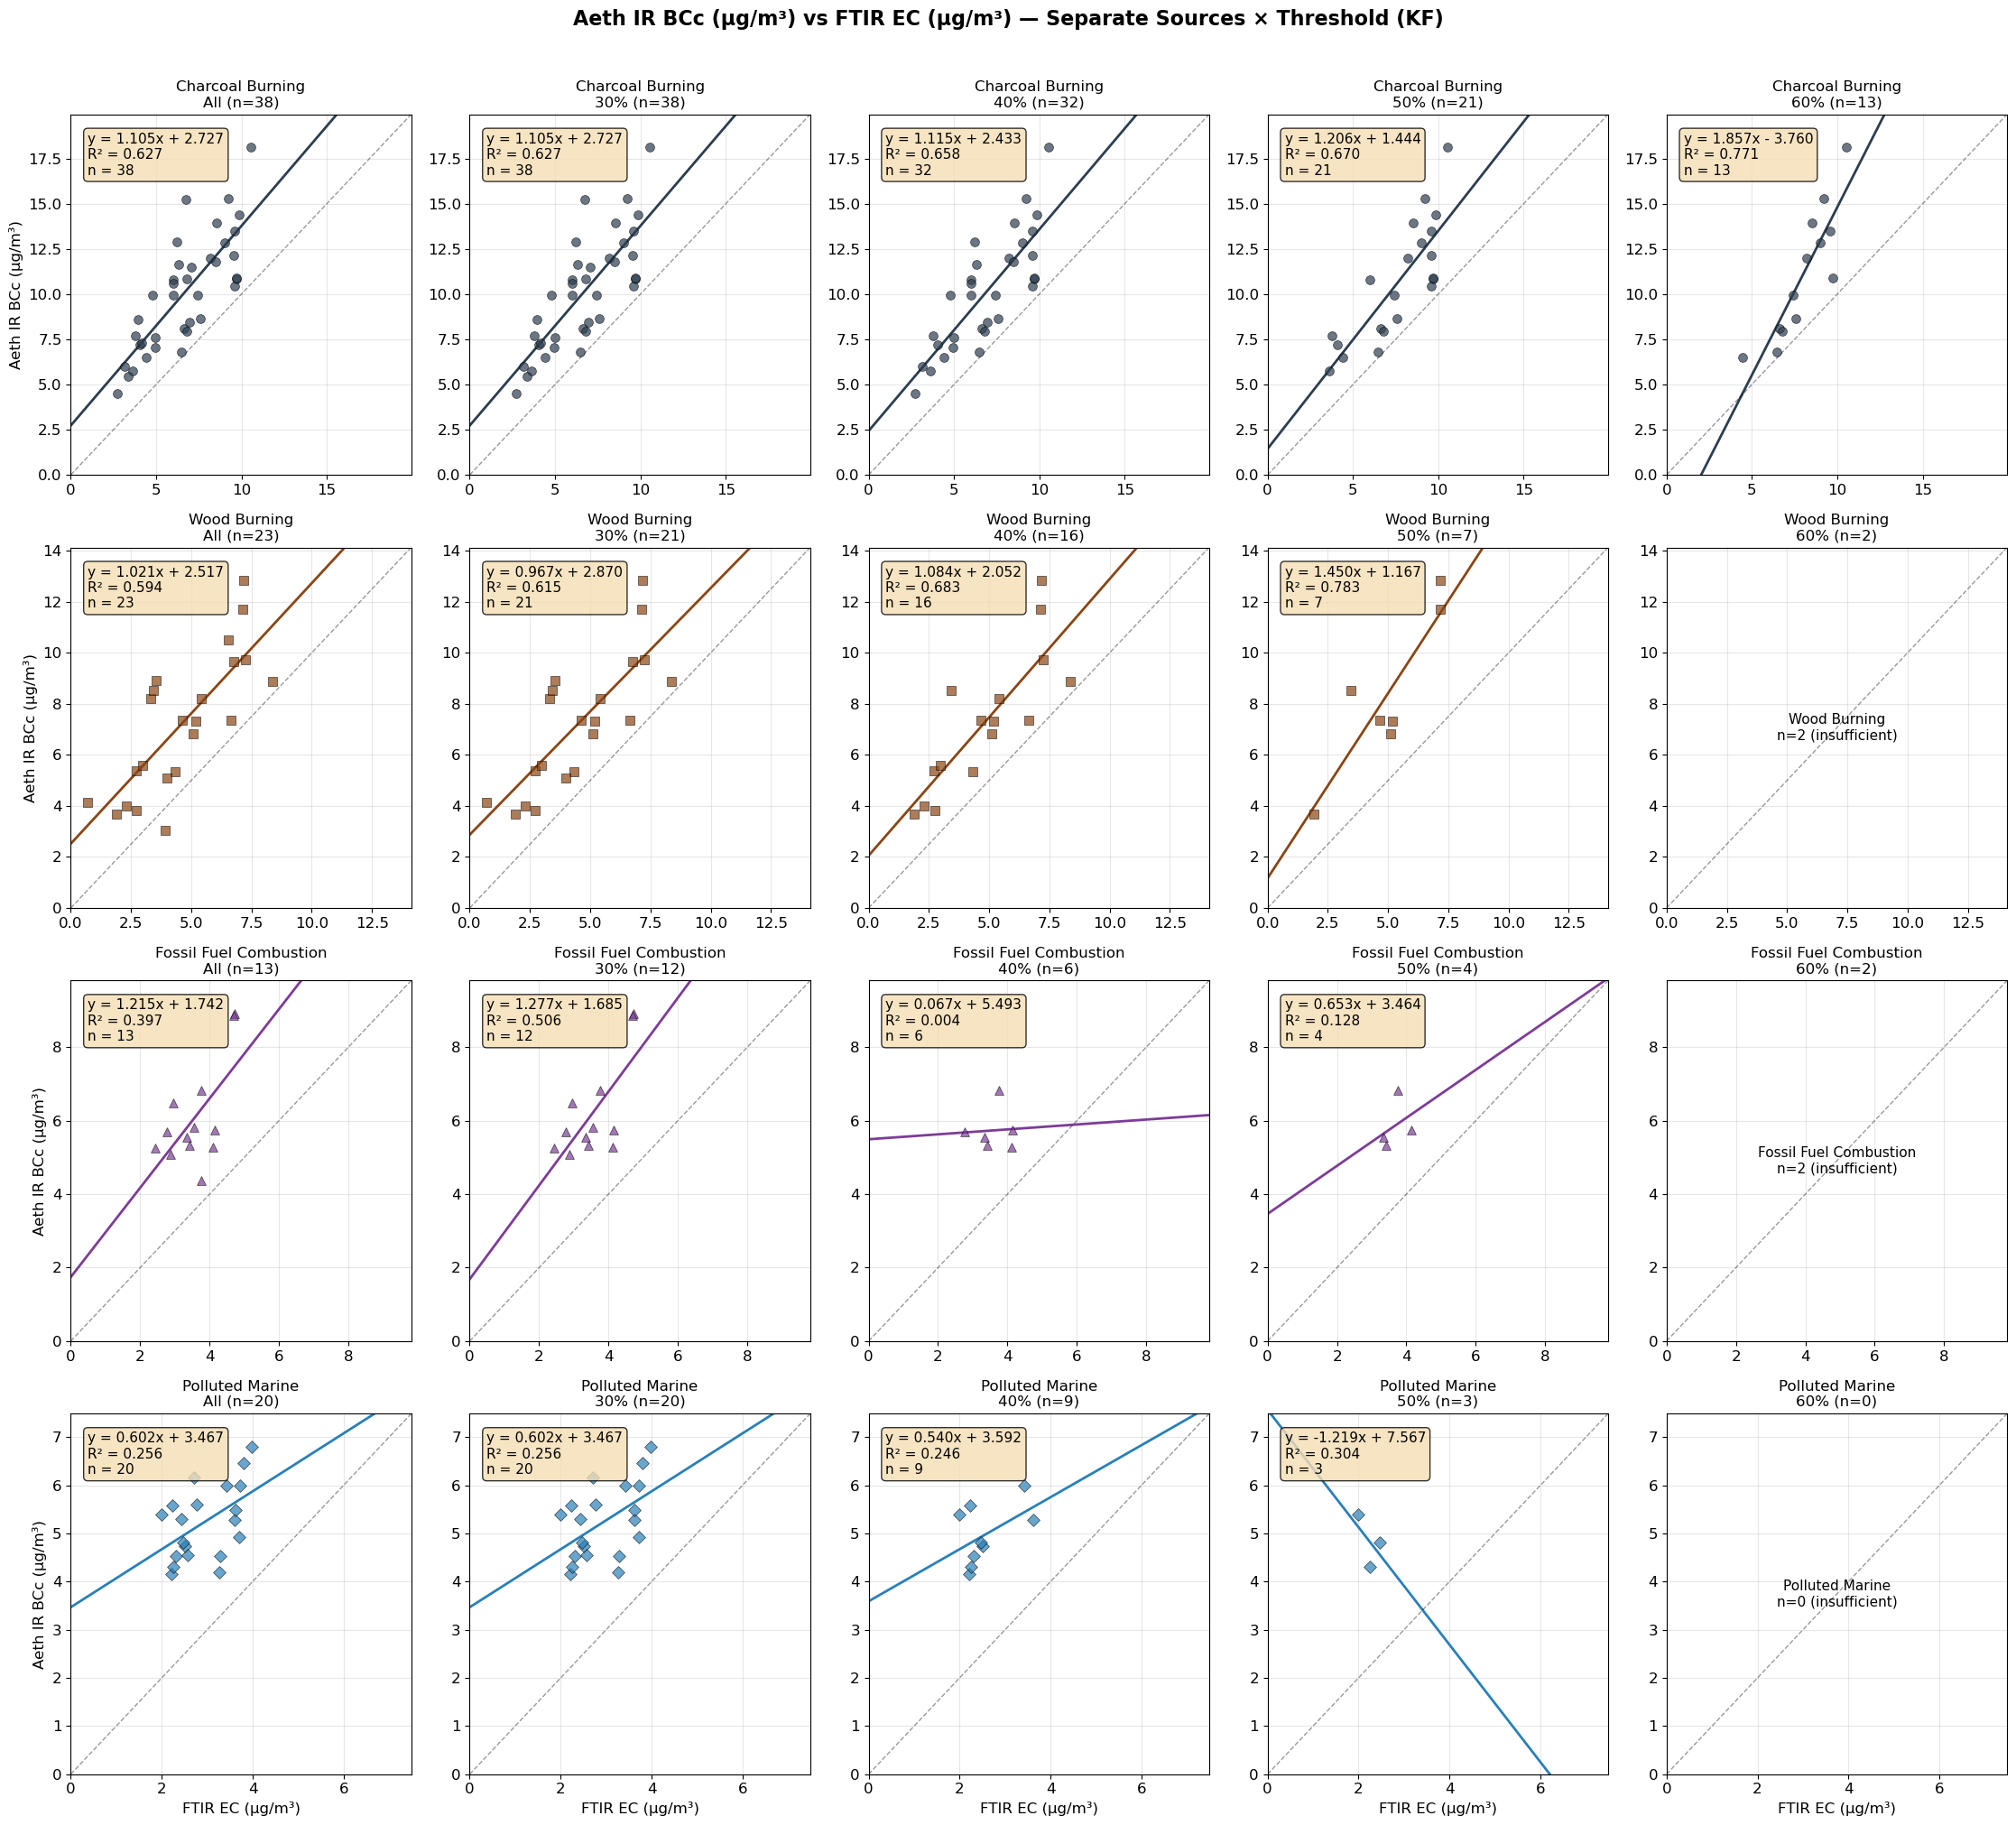


────────────────────────────────────────────────────────────
AETH_VS_HIPS
────────────────────────────────────────────────────────────


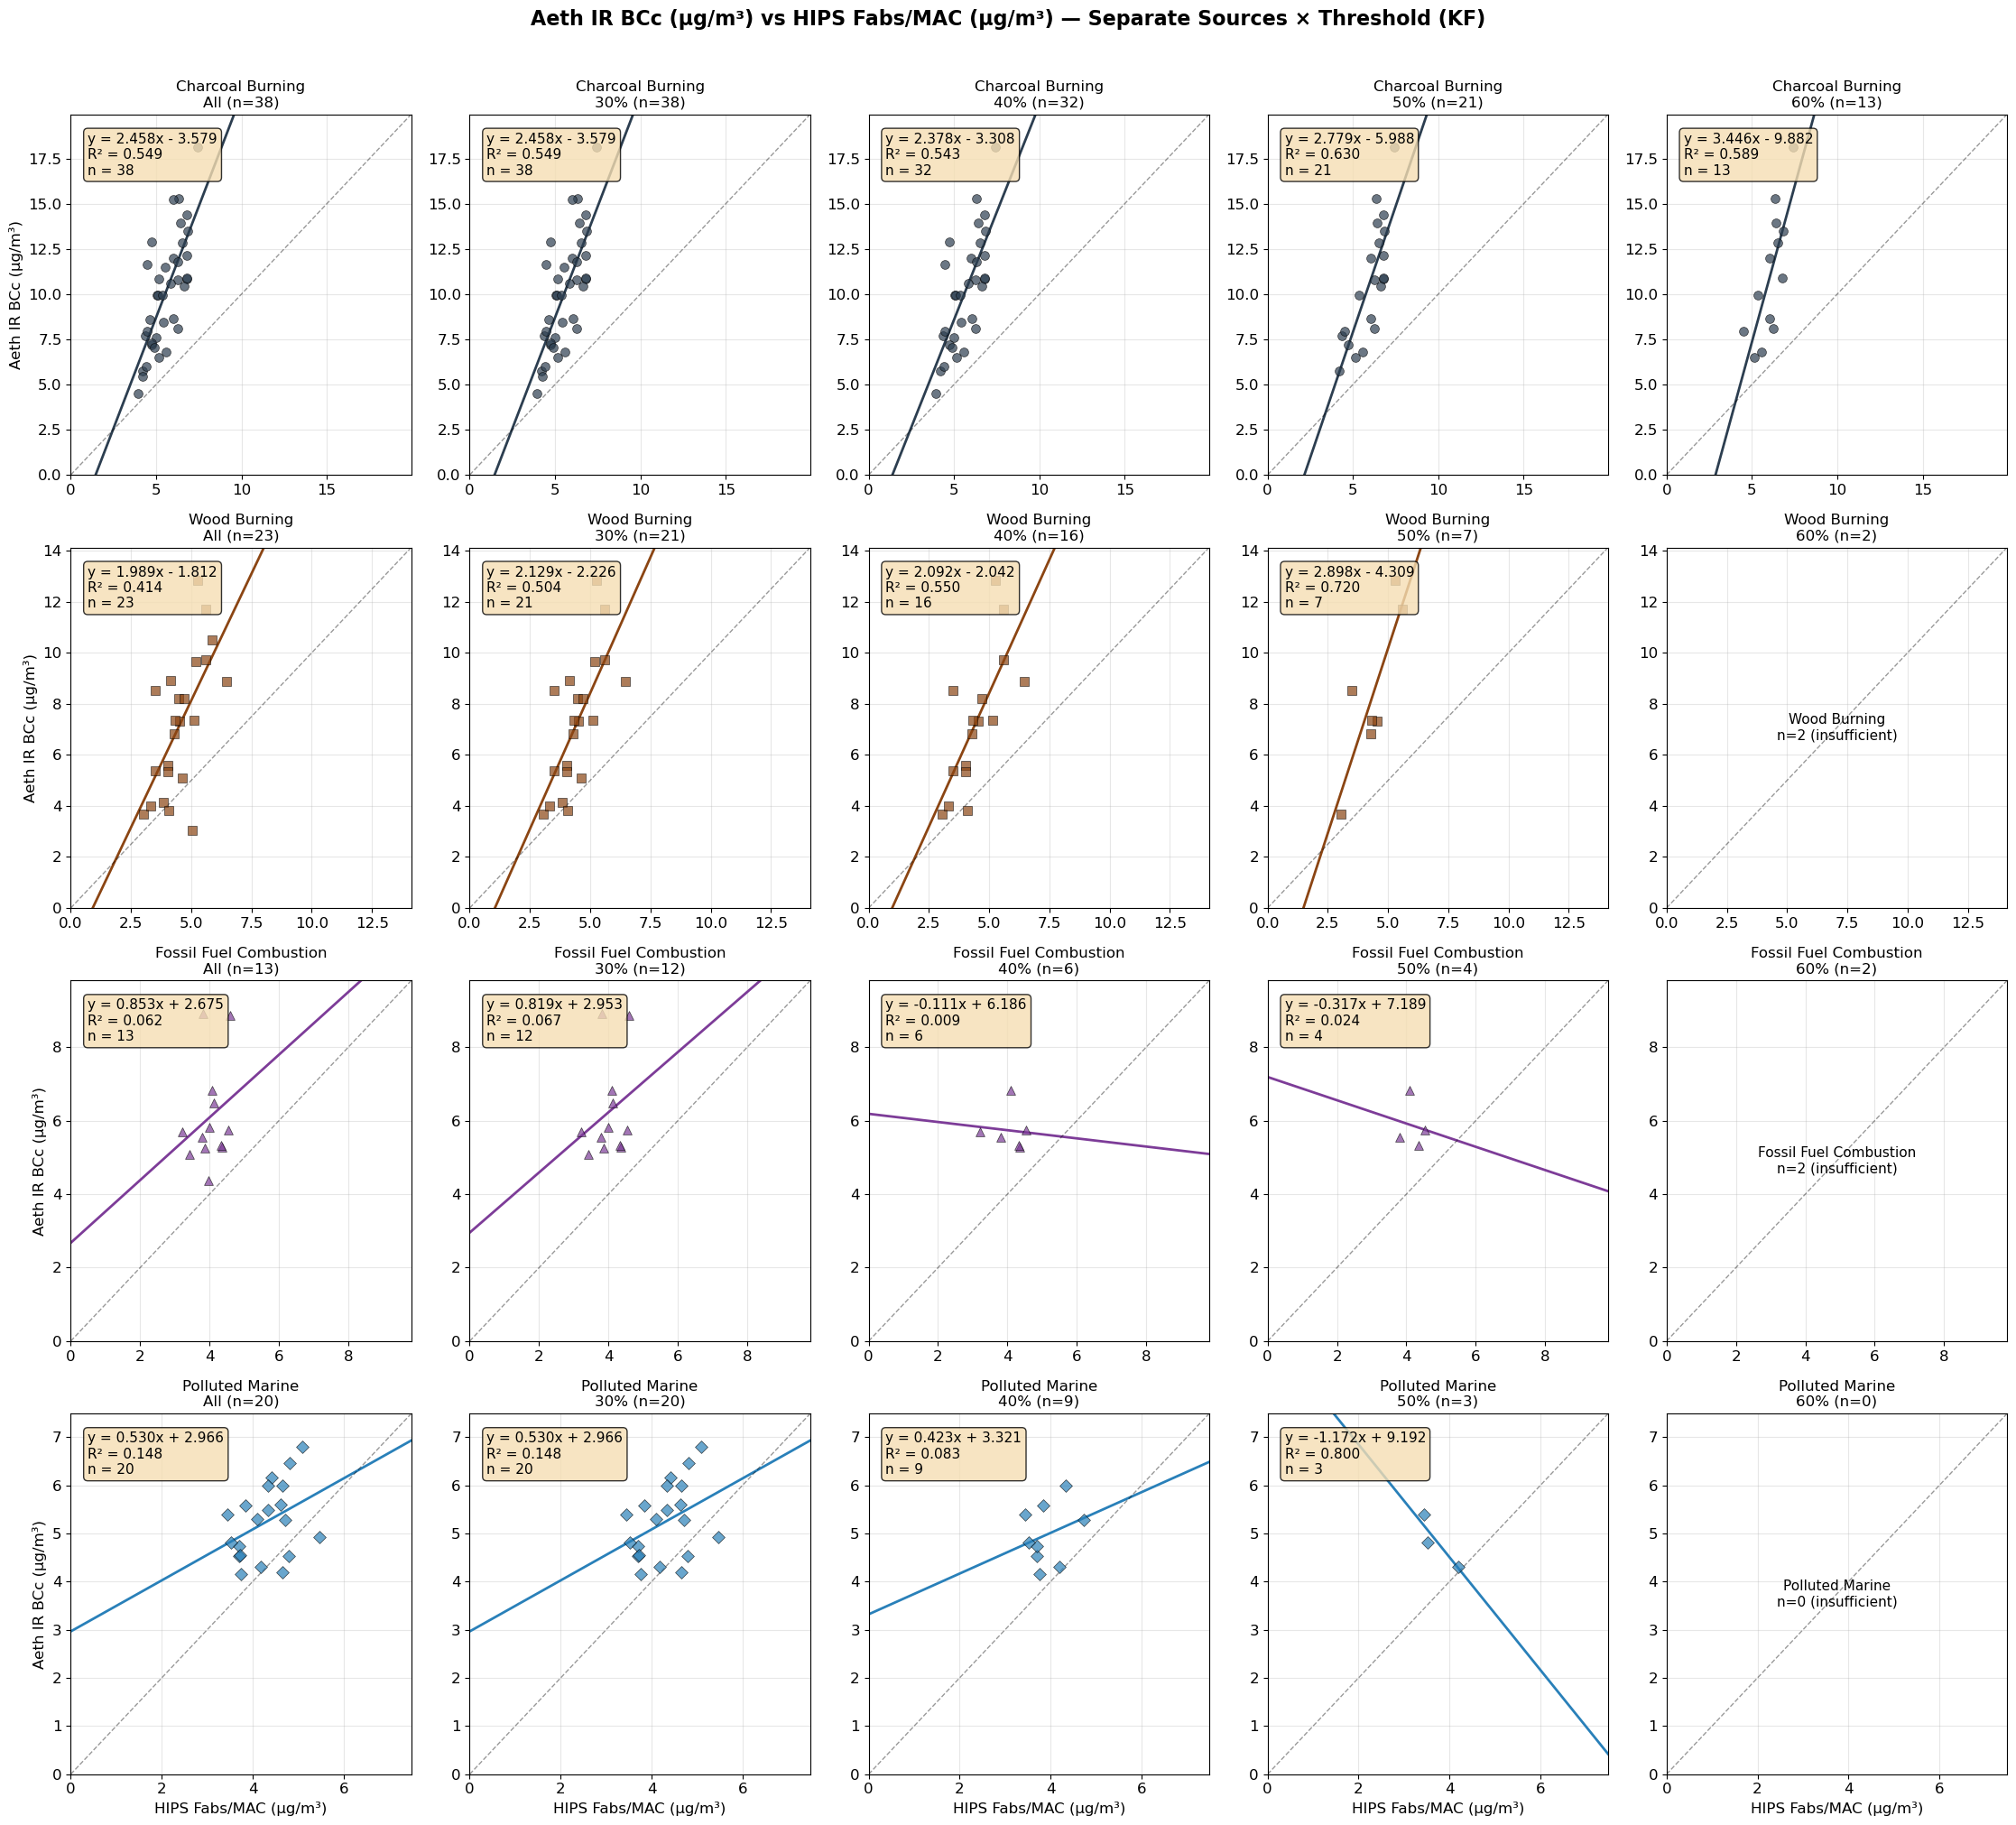

In [129]:
# =============================================================================
# Threshold-Filtered Cross-Plots: SEPARATE Sources
# =============================================================================

print("=" * 80)
print("THRESHOLD ANALYSIS: SEPARATE SOURCES")
print("=" * 80)

threshold_results_separate = {}

for x_col, y_col, x_label, y_label, pair_name in MEASUREMENT_PAIRS:
    print(f"\n{'─' * 60}")
    print(f"{pair_name.upper()}")
    print(f"{'─' * 60}")
    
    thresholds = [None] + DOMINANCE_THRESHOLDS
    n_cols = len(thresholds)
    sources_to_plot = [s for s in SOURCE_ORDER if s != 'sea_salt']
    n_rows = len(sources_to_plot)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 5*n_rows))
    
    pair_results = {}
    
    for row_idx, source in enumerate(sources_to_plot):
        info = SOURCE_CATEGORIES[source]
        
        # Compute axis limit across all thresholds for this source
        all_source_mask = df['dominant_source'] == source
        all_source_data = df[all_source_mask].dropna(subset=[x_col, y_col])
        all_v_source = np.concatenate([all_source_data[x_col].values, all_source_data[y_col].values])
        row_lim = max(all_v_source) * 1.1 if len(all_v_source) > 0 else 1
        
        for col_idx, thresh in enumerate(thresholds):
            ax = axes[row_idx, col_idx]
            
            mask = df['dominant_source'] == source
            if thresh is not None:
                mask = mask & (df['dominant_fraction'] >= thresh)
            
            subset = df[mask].dropna(subset=[x_col, y_col])
            
            res = plot_regression(
                ax, subset[x_col].values, subset[y_col].values,
                info['color'], info['marker'], info['label'],
                xlim=(0, row_lim)
            )
            
            thresh_label = 'All' if thresh is None else f'{thresh*100:.0f}%'
            ax.set_title(f"{info['label']}\n{thresh_label} (n={res['n']})",
                        fontsize=FONT_CONFIG['tick'])
            
            if col_idx == 0:
                ax.set_ylabel(y_label, fontsize=FONT_CONFIG['tick'])
            if row_idx == n_rows - 1:
                ax.set_xlabel(x_label, fontsize=FONT_CONFIG['tick'])
            
            ax.grid(True, alpha=0.3)
            
            # 1:1 line and consistent axis limits
            ax.plot([0, row_lim], [0, row_lim], 'k--', alpha=0.4, linewidth=1)
            ax.set_xlim(0, row_lim)
            ax.set_ylim(0, row_lim)
            
            pair_results[(source, thresh_label)] = res
    
    plt.suptitle(f'{y_label} vs {x_label} — Separate Sources × Threshold (KF)',
                fontsize=FONT_CONFIG['title'], fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(dirs['plots'], f'threshold_separate_{pair_name}.png'),
                dpi=150, bbox_inches='tight')
    plt.show()
    
    threshold_results_separate[pair_name] = pair_results

---

# Section 6: Seasonal Write-Up — Concentration Patterns

**Ann's request**: Write up what you learned from the concentration plot:
- Higher concentrations during rain?
- Higher biomass in summer?
- Seasonal source dominance shifts

---

In [130]:
# =============================================================================
# Seasonal Statistics: Source Concentrations by Season
# =============================================================================

print("=" * 80)
print("SEASONAL SOURCE CONCENTRATION STATISTICS")
print("=" * 80)

conc_cols_available = [c for c in conc_cols if c in df.columns]

for season in SEASONS_ORDER:
    season_data = df[df['season_3'] == season]
    print(f"\n--- {season} (n={len(season_data)}) ---")
    
    if len(season_data) == 0:
        continue
    
    for col in conc_cols_available:
        source_name = col.replace('_conc', '').replace('_', ' ').title()
        vals = season_data[col].dropna()
        if len(vals) > 0:
            print(f"  {source_name:<25s}  mean={vals.mean():.3f}  median={vals.median():.3f}  std={vals.std():.3f}  n={len(vals)}")
    
    # Total KF
    if 'kf_total' in season_data.columns:
        total = season_data['kf_total'].dropna()
        print(f"  {'TOTAL KF':<25s}  mean={total.mean():.3f}  median={total.median():.3f}  std={total.std():.3f}")
    
    # Grouped
    if 'biomass_conc' in season_data.columns:
        bio = season_data['biomass_conc'].dropna()
        fos = season_data['fossil_comb_conc'].dropna()
        print(f"  {'Biomass (grouped)':<25s}  mean={bio.mean():.3f}")
        print(f"  {'Fossil Fuel (grouped)':<25s}  mean={fos.mean():.3f}")

SEASONAL SOURCE CONCENTRATION STATISTICS

--- Dry Season (n=146) ---
  Charcoal                   mean=0.595  median=0.306  std=0.729  n=40
  Wood                       mean=0.784  median=0.812  std=0.617  n=40
  Fossil Fuel                mean=0.968  median=0.764  std=0.936  n=40
  Polluted Marine            mean=1.306  median=1.270  std=0.534  n=40
  Sea Salt                   mean=0.533  median=0.401  std=0.616  n=40
  TOTAL KF                   mean=1.147  median=0.000  std=1.994
  Biomass (grouped)          mean=0.378
  Fossil Fuel (grouped)      mean=0.623

--- Belg Rainy Season (n=102) ---
  Charcoal                   mean=2.445  median=2.135  std=2.513  n=26
  Wood                       mean=1.404  median=1.160  std=0.790  n=26
  Fossil Fuel                mean=0.464  median=0.247  std=0.534  n=26
  Polluted Marine            mean=0.454  median=0.454  std=0.352  n=26
  Sea Salt                   mean=0.465  median=0.437  std=0.405  n=26
  TOTAL KF                   mean=1.334  

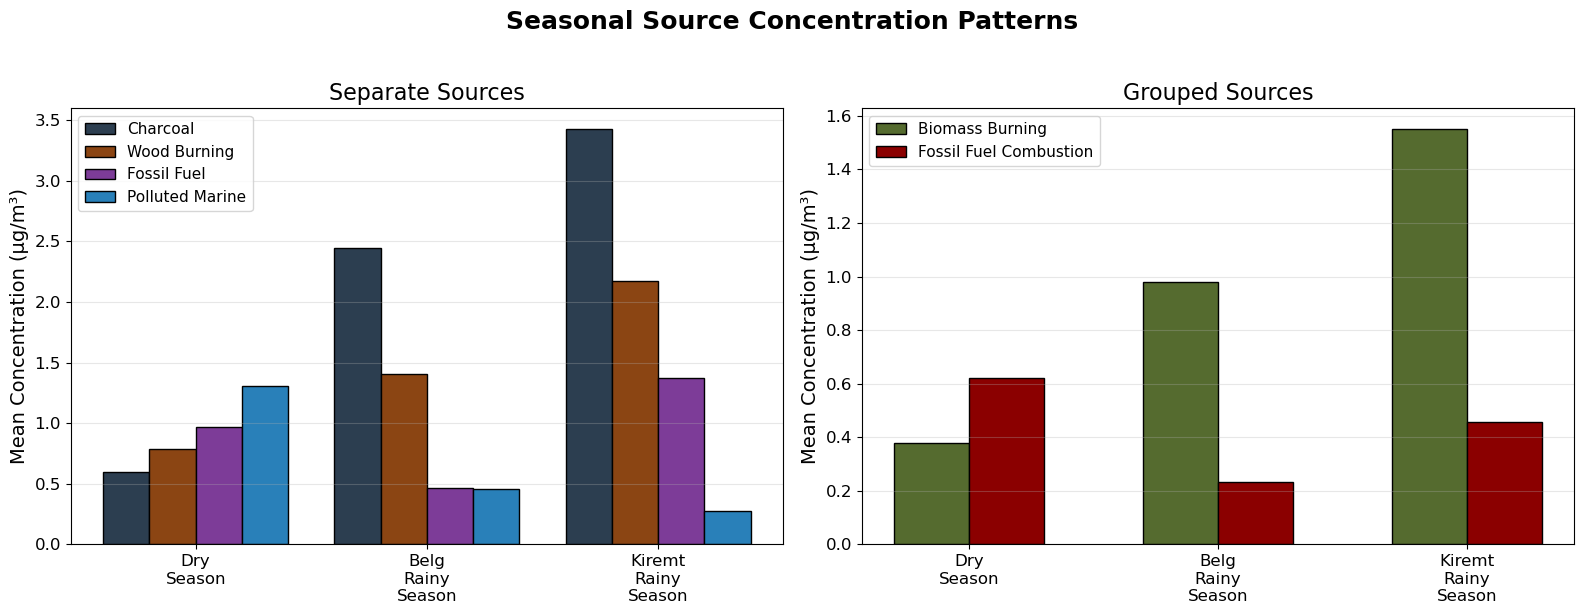

In [131]:
# =============================================================================
# Seasonal Bar Chart: Mean Source Concentrations by Season
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Separate sources by season
ax = axes[0]
separate_source_names = ['charcoal_conc', 'wood_conc', 'fossil_fuel_conc', 'polluted_marine_conc']
separate_labels = ['Charcoal', 'Wood Burning', 'Fossil Fuel', 'Polluted Marine']
separate_colors = [SOURCE_CATEGORIES[s]['color'] for s in ['charcoal', 'wood', 'fossil_fuel', 'polluted_marine']]

x = np.arange(len(SEASONS_ORDER))
width = 0.2

for i, (col, label, color) in enumerate(zip(separate_source_names, separate_labels, separate_colors)):
    if col in df.columns:
        means = [df[df['season_3'] == s][col].mean() for s in SEASONS_ORDER]
        ax.bar(x + i*width - width*1.5, means, width, label=label, color=color, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels([s.replace(' ', '\n') for s in SEASONS_ORDER], fontsize=FONT_CONFIG['tick'])
ax.set_ylabel('Mean Concentration (µg/m³)', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Separate Sources', fontsize=FONT_CONFIG['title'])
ax.legend(fontsize=FONT_CONFIG['legend'] - 1)
ax.grid(True, axis='y', alpha=0.3)

# Panel 2: Grouped sources by season
ax = axes[1]
grouped_cols = ['biomass_conc', 'fossil_comb_conc']
grouped_labels = ['Biomass Burning', 'Fossil Fuel Combustion']
grouped_colors = [GROUPED_SOURCE_CATEGORIES['biomass_burning']['color'],
                  GROUPED_SOURCE_CATEGORIES['fossil_fuel_combustion']['color']]

width = 0.3
for i, (col, label, color) in enumerate(zip(grouped_cols, grouped_labels, grouped_colors)):
    if col in df.columns:
        means = [df[df['season_3'] == s][col].mean() for s in SEASONS_ORDER]
        ax.bar(x + i*width - width*0.5, means, width, label=label, color=color, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels([s.replace(' ', '\n') for s in SEASONS_ORDER], fontsize=FONT_CONFIG['tick'])
ax.set_ylabel('Mean Concentration (µg/m³)', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Grouped Sources', fontsize=FONT_CONFIG['title'])
ax.legend(fontsize=FONT_CONFIG['legend'] - 1)
ax.grid(True, axis='y', alpha=0.3)

plt.suptitle('Seasonal Source Concentration Patterns',
             fontsize=FONT_CONFIG['title'] + 2, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(dirs['friday_slides'], 'seasonal_source_concentrations.png'),
            dpi=200, bbox_inches='tight')
plt.show()

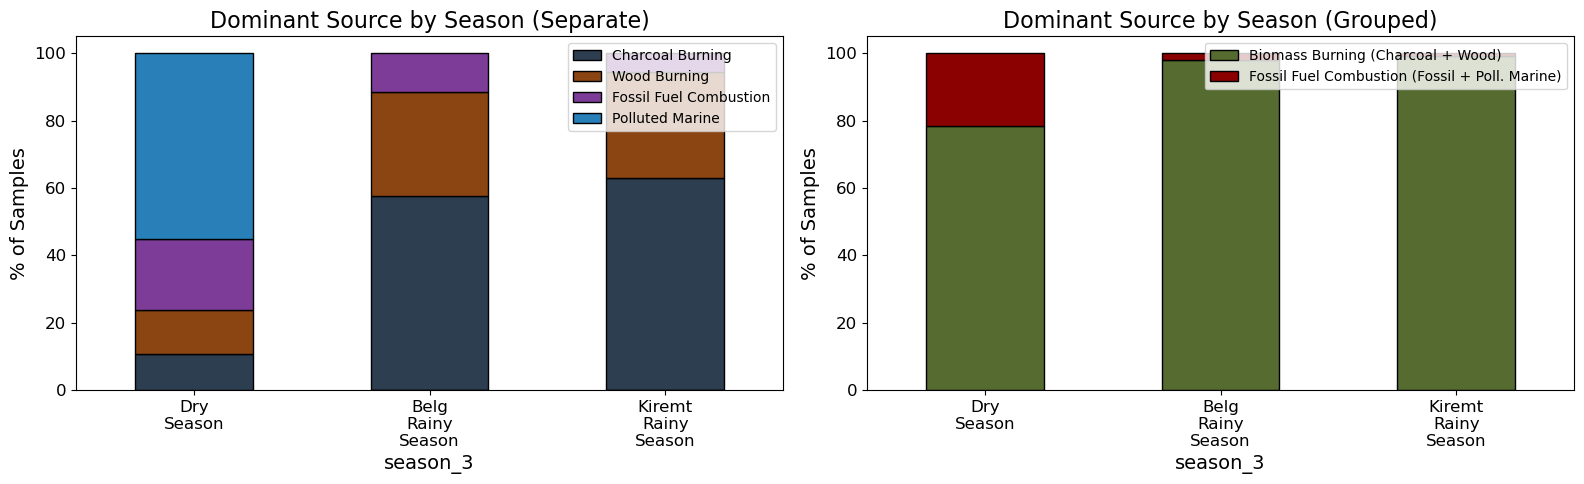

In [132]:
# =============================================================================
# Dominant Source Distribution by Season
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Panel 1: Separate sources
ax = axes[0]
ct_sep = pd.crosstab(df['season_3'], df['dominant_source'])
ct_sep = ct_sep.reindex(columns=[s for s in SOURCE_ORDER if s != 'sea_salt'], fill_value=0)
ct_sep = ct_sep.reindex(SEASONS_ORDER)
ct_sep_pct = ct_sep.div(ct_sep.sum(axis=1), axis=0) * 100

ct_sep_pct.plot(kind='bar', stacked=True, ax=ax,
                color=[SOURCE_CATEGORIES[s]['color'] for s in ct_sep_pct.columns],
                edgecolor='black')
ax.set_ylabel('% of Samples', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Dominant Source by Season (Separate)', fontsize=FONT_CONFIG['title'])
ax.set_xticklabels([s.replace(' ', '\n') for s in SEASONS_ORDER], rotation=0,
                    fontsize=FONT_CONFIG['tick'])
ax.legend([SOURCE_CATEGORIES[s]['label'] for s in ct_sep_pct.columns],
          fontsize=FONT_CONFIG['legend'] - 2, loc='upper right')

# Panel 2: Grouped sources
ax = axes[1]
ct_grp = pd.crosstab(df['season_3'], df['dominant_source_grouped'])
ct_grp = ct_grp.reindex(columns=[s for s in GROUPED_SOURCE_ORDER if s != 'sea_salt'], fill_value=0)
ct_grp = ct_grp.reindex(SEASONS_ORDER)
ct_grp_pct = ct_grp.div(ct_grp.sum(axis=1), axis=0) * 100

ct_grp_pct.plot(kind='bar', stacked=True, ax=ax,
                color=[GROUPED_SOURCE_CATEGORIES[s]['color'] for s in ct_grp_pct.columns],
                edgecolor='black')
ax.set_ylabel('% of Samples', fontsize=FONT_CONFIG['axis_label'])
ax.set_title('Dominant Source by Season (Grouped)', fontsize=FONT_CONFIG['title'])
ax.set_xticklabels([s.replace(' ', '\n') for s in SEASONS_ORDER], rotation=0,
                    fontsize=FONT_CONFIG['tick'])
ax.legend([GROUPED_SOURCE_CATEGORIES[s]['label'].replace('\n', ' ') for s in ct_grp_pct.columns],
          fontsize=FONT_CONFIG['legend'] - 2, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(dirs['plots'], 'dominant_source_by_season.png'),
            dpi=150, bbox_inches='tight')
plt.show()

---

# Section 7: Notes & Flags

---

## ⚠️ GF Values — DROP THEM (Ann's instruction)

Ann was clear: **forget about GF entirely**.

**Action items:**
- Remove any GF-based slides from the Friday deck
- All source dominance should use K_F (concentration) values
- The KF-based fractions (Section 1) replace the GF fractions
- Do not show GF and KF side-by-side — just KF

**Slides to remove/replace:**
- Any slides showing GF-based dominance determination
- Any threshold analysis using GF method
- The "GF vs KF comparison" slides from `dominant_source_comparison.ipynb`

---

## 🔍 Flag: Addis Adjustment vs Delhi — Is it driving different behavior?

**Ann's question**: Is the adjustment done for Addis causing different behavior than Delhi?  
**Status**: Unknown — neither Ann nor Ahmad knew the answer.  
**Action**: Investigate when splitting sites.

### What to check:
1. What adjustment was applied to Addis data specifically?
2. Compare regression slopes/intercepts between Addis and Delhi
3. Look at whether source-separated behavior differs between sites
4. If Addis has a site-specific correction, test with and without it

### When to do this:
- When working on the "show Addis Ababa and Delhi data both separately and combined" task
- Flag this explicitly in the site context framing slides

---

## 📧 Email Actions Required

1. **Email Naveed**: Request his R script used to generate the source fraction plot  
   - Confirm the KF-based recalculation matches his approach
   - Confirm factor identifications (F1–F5) match current labeling
   - ~~Ask about GF variable meaning~~ (no longer needed — dropping GF)
   
2. **Verify precipitation data source** with Naveed for group consistency

---

## Friday Summary Checklist

### Slides to prepare:

- [ ] **(a) Source concentration time series** (KF µg/m³ stacked bars with season strip)  
      → `friday_slides/source_concentration_timeseries.png`
      
- [ ] **(a) KF-based fraction time series** (Figure 7 replication)  
      → `friday_slides/fig7_kf_fractions.png`
      
- [ ] **(b) Cross-plot with slopes by source** (separate sources)  
      → `friday_slides/crossplot_separate_hips_vs_ec.png` (and aeth variants)
      
- [ ] **(b) Cross-plot with slopes by source** (grouped sources)  
      → `friday_slides/crossplot_grouped_hips_vs_ec.png` (and aeth variants)
      
- [ ] **Write-up**: What was learned from concentration plot  
      - Higher/lower concentrations by season
      - Biomass burning patterns (summer increase?)
      - Concentration during rainy vs dry seasons
      
- [ ] **Remove all GF-based slides** from the deck

### Remaining tasks (not for Friday):
- [ ] Add Addis + Delhi overview/context slides
- [ ] Show both sites separately and combined (color-coded)
- [ ] Investigate Addis adjustment effect on behavior vs Delhi
- [ ] Literature search on Aeronet AOD applications